# Exploratory Data Anaysis
## Load Dependencies

In [1]:
import csv
import pandas as pd
import numpy as np
from functools import reduce
import requests
import time
from datetime import datetime
import requests.exceptions
import os
import json
import random
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

## Load Dataframes

In [6]:
wine_scores = pd.read_csv('data\clean\cleaned_combined_wine_data.csv')
weather_data = pd.read_csv('data\clean\combined_weather_data_clean.csv')

In [7]:
# Sanity Check
wine_scores.head()

Wine Name Region 1 Region 2 Region 3  \
0    Calem 1961 Colheita Tawny Port (Port)      NaN     Port      NaN   
1        Calem 1961 Colheita Tawny  (Port)      NaN     Port      NaN   
2   Warre's 1961 Reserve Tawny Port (Port)      NaN     Port      NaN   
3  Wiese & Krohn 1961 Colheita Port (Port)      NaN     Port      NaN   
4       Cossart Gordon 1962 Bual (Madeira)      NaN  Madeira      NaN   

    Country  Score  Price          Winery     Variety  Vintage  
0  Portugal     95  320.0           Calem  Port Blend     1961  
1  Portugal     95  320.0           Calem        Port     1961  
2  Portugal     89  111.0         Warre's  Port Blend     1961  
3  Portugal     92  200.0   Wiese & Krohn  Port Blend     1961  
4  Portugal     96  355.0  Cossart Gordon     Madeira     1962

In [5]:
weather_data.head()

Station ID    Country                   City  Data Type  Year    Jan  \
0        5046  INDONESIA  KIJANG TANJUNG PINANG          4  1993   25.6   
1        5046  INDONESIA  KIJANG TANJUNG PINANG          4  1995   26.0   
2        5046  INDONESIA  KIJANG TANJUNG PINANG          5  1993  246.6   
3        5046  INDONESIA  KIJANG TANJUNG PINANG          5  1995  388.0   
4        5046  INDONESIA  KIJANG TANJUNG PINANG          6  1993   29.6   

     Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec  
0   25.6   25.7   26.0   25.9   26.8   25.8   26.3   25.8   25.4   25.4   25.9  
1   25.6   25.9   26.0   26.6   26.6   26.3   26.2   26.7   26.1   25.9   25.6  
2   61.9  285.8  324.2  424.1  169.6  261.7  157.9  240.3  398.5  473.6  683.9  
3  325.1  190.7  357.9  299.5  334.3  250.9  213.4  265.6  496.3  630.8  277.1  
4   30.7   30.6   31.3   29.8   31.2   30.7   31.3   30.7   30.3   29.9   29.9

## Working Dataframes
We need to create some temporary working dataframes for us to do preliminary data exploration. First lets reduce the amount of weather data we have by just grabbing the data from countries and years that we have wines for.

In [10]:
wine_data_df = pd.read_csv('data\clean\cleaned_combined_wine_data.csv')
weather_data_df = pd.read_csv('data\clean\combined_weather_data_clean.csv')

# Rename the 'Vintage' column in wine_data_df to 'Year' for consistency
wine_data_df.rename(columns={'Vintage': 'Year'}, inplace=True)

# Standardize country names in wine data to uppercase for matching
wine_data_df['Country'] = wine_data_df['Country'].str.upper()

# Filter the weather data to only include rows that match the Country and Year in the wine data
matched_weather_data = weather_data_df[weather_data_df[['Country', 'Year']].apply(tuple, 1).isin(wine_data_df[['Country', 'Year']].apply(tuple, 1))]

# Reset the index of the DataFrame
matched_weather_data.reset_index(drop=True, inplace=True)

# Display the first few rows of the filtered weather data
matched_weather_data.head()

Station ID      Country                        City  Data Type  Year   Jan  \
0           0    AUSTRALIA  SCONE SOIL CONS          0          4  1985  24.6   
1           0    AUSTRALIA  SCONE SOIL CONS          0          4  1987  25.7   
2           0    AUSTRALIA  SCONE SOIL CONS          0          5  1985   4.6   
3           0    AUSTRALIA  SCONE SOIL CONS          0          5  1987  90.6   
4        6600  SWITZERLAND              ST. CHRISCHONA          4  2004   0.9   

    Feb   Mar   Apr   May   Jun   Jul    Aug   Sep    Oct   Nov    Dec  
0  22.4  21.5  17.7  14.2  10.2  10.6   11.3  13.2   17.2  19.1   22.8  
1  24.7  19.6  17.9  14.2  12.0  10.1   13.1  14.8   17.1  20.0   22.6  
2  88.8  48.6  53.8  36.2  55.2  17.0   45.2  76.4  143.2  33.4  121.6  
3   4.8  82.8   5.0  73.4  20.8   9.8  110.2  19.2   42.6  41.0  113.8  
4   2.3   4.8   9.5  11.7  15.7  17.2   17.7  14.4   10.7   4.0    0.2

Now we want to get rid of the Data Type column, so its easier for someone to read all relevant weather data in one dataframe. Atomosphereric pressure isn't relevant for what we are trying to calculate, and not to mention not all locations measure atomosphereric pressure, so we will be getting ride of data type 2 and 3 if it ever pops up.

In [16]:
# Function to rename columns based on the data type
def rename_columns(df, data_type):
    prefix = {
        4: 'daily_temp',
        5: 'precipitation',
        6: 'daily_temp_MAX',
        7: 'daily_temp_MIN',
        8: 'humidity'
    }.get(data_type, 'unknown')

    month_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    new_month_cols = [f'{prefix}_{month}' for month in month_cols]
    rename_dict = dict(zip(month_cols, new_month_cols))
    df.rename(columns=rename_dict, inplace=True)
    return df

# Splitting the DataFrame into separate DataFrames based on Data Type
dfs = {}
for dtype in [4, 5, 6, 7, 8]:
    df = matched_weather_data[matched_weather_data['Data Type'] == dtype].copy()
    df = rename_columns(df, dtype)
    dfs[dtype] = df

# Drop the 'Data Type' column from each DataFrame and rename the month columns
for dtype, df in dfs.items():
    df = df.drop(columns=['Data Type'])
    df = rename_columns(df, dtype)
    dfs[dtype] = df
    
# Merge the DataFrames back together with explicit suffixes for overlapping columns
merged_weather_df = reduce(lambda left, right: pd.merge(left, right, on=['Station ID', 'Country', 'City', 'Year'], how='outer', suffixes=('', '_duplicate')), dfs.values())

# Remove any columns that were duplicated during the merge
merged_weather_df = merged_weather_df[[col for col in merged_weather_df.columns if not col.endswith('_duplicate')]]

# Reset the index of the DataFrame
merged_weather_df.reset_index(drop=True, inplace=True)

# Check results
merged_weather_df.head()

Station ID      Country                        City  Year  daily_temp_Jan  \
0           0    AUSTRALIA  SCONE SOIL CONS          0  1985            24.6   
1           0    AUSTRALIA  SCONE SOIL CONS          0  1987            25.7   
2        6600  SWITZERLAND              ST. CHRISCHONA  2004             0.9   
3        6601  SWITZERLAND           BASEL / BINNINGEN  2004             2.3   
4        6601  SWITZERLAND           BASEL / BINNINGEN  2011             2.4   

   daily_temp_Feb  daily_temp_Mar  daily_temp_Apr  daily_temp_May  \
0            22.4            21.5            17.7            14.2   
1            24.7            19.6            17.9            14.2   
2             2.3             4.8             9.5            11.7   
3             3.0             5.7            10.6            13.2   
4             3.9             7.5            13.4            16.6   

   daily_temp_Jun  ...  humidity_Mar  humidity_Apr  humidity_May  \
0            10.2  ...           NaN           NaN           NaN   
1            12.0  ...           NaN           NaN           NaN   
2            15.7  ...           NaN           NaN           NaN   
3            17.7  ...           NaN           NaN           NaN   
4            18.1  ...           NaN           NaN           NaN   

   humidity_Jun  humidity_Jul  humidity_Aug  humidity_Sep  humidity_Oct  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   humidity_Nov  humidity_Dec  
0           NaN           NaN  
1           NaN           NaN  
2           NaN           NaN  
3           NaN           NaN  
4           NaN           NaN  

[5 rows x 64 columns]

In [17]:
merged_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40321 entries, 0 to 40320
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station ID          40321 non-null  int64  
 1   Country             40321 non-null  object 
 2   City                40321 non-null  object 
 3   Year                40321 non-null  int64  
 4   daily_temp_Jan      39238 non-null  float64
 5   daily_temp_Feb      39238 non-null  float64
 6   daily_temp_Mar      39238 non-null  float64
 7   daily_temp_Apr      39238 non-null  float64
 8   daily_temp_May      39238 non-null  float64
 9   daily_temp_Jun      39238 non-null  float64
 10  daily_temp_Jul      39238 non-null  float64
 11  daily_temp_Aug      39238 non-null  float64
 12  daily_temp_Sep      39238 non-null  float64
 13  daily_temp_Oct      39238 non-null  float64
 14  daily_temp_Nov      39238 non-null  float64
 15  daily_temp_Dec      39238 non-null  float64
 16  prec

In [18]:
# Save dataframe to CSV
merged_weather_df.to_csv('data\clean\merged_weather.csv', index=False)

Next we will filter out wine data that have matching location and vintages.

In [21]:
# Load Dataframes
wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')
merged_weather_df = pd.read_csv('data\clean\merged_weather.csv')

# Create a temporary DataFrame with unique city-country pairs
unique_city_country = merged_weather_df[['City', 'Country']].drop_duplicates()
unique_city_country['City'] = unique_city_country['City'].str.upper()
unique_city_country['City Words'] = unique_city_country['City'].apply(lambda x: x.split())

# Function to check for any matching word and country match
def any_matching_word_and_country(row, city_country_df):
    for region_key in ['Region 1', 'Region 2', 'Region 3']:
        region = row[region_key]
        if pd.notna(region):
            region_words = set(region.upper().split())
            for _, city_country_row in city_country_df.iterrows():
                if any(word in region_words for word in city_country_row['City Words']) and row['Country'].upper() == city_country_row['Country'].upper():
                    return True
    return False

# Ensure all relevant columns are strings and handle NaNs
wine_data[['Region 1', 'Region 2', 'Region 3']] = wine_data[['Region 1', 'Region 2', 'Region 3']].fillna('').astype(str)
wine_data['Country'] = wine_data['Country'].fillna('').astype(str)

# Filter wine_data
filtered_wine_data = wine_data[wine_data.apply(lambda row: any_matching_word_and_country(row, unique_city_country), axis=1)]

# Check result
filtered_wine_data.head()

Wine Name      Region 1  \
43  Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...     Andalucia   
75           Adega de Favaios 1980  Moscatel do Douro                 
77  Adega de Favaios 1980 Moscatel (Moscatel do Do...                 
79          Cuva Vella 1980 Vintage Muscat (Valencia)       Levante   
87  Moulin Touchais 1982 Chenin Blanc (Coteaux du ...  Loire Valley   

             Region 2          Region 3   Country  Score  Price  \
43                                Jerez     Spain     85   40.0   
75  Moscatel do Douro                    Portugal     93  137.0   
77  Moscatel do Douro                    Portugal     93  137.0   
79                             Valencia     Spain     90   65.0   
87                     Coteaux du Layon    France     95   64.0   

                    Winery       Variety  Vintage  
43  Bodegas Dios Baco S.L.        Sherry     1970  
75        Adega de Favaios      Moscatel     1980  
77        Adega de Favaios        Muscat     1980  
79              Cuva Vella        Muscat     1980  
87         Moulin Touchais  Chenin Blanc     1982

In [22]:
# Reset the index of the DataFrame
filtered_wine_data.reset_index(drop=True, inplace=True)

# Check result
filtered_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16760 entries, 0 to 16759
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wine Name  16760 non-null  object 
 1   Region 1   16760 non-null  object 
 2   Region 2   16760 non-null  object 
 3   Region 3   16760 non-null  object 
 4   Country    16760 non-null  object 
 5   Score      16760 non-null  int64  
 6   Price      15406 non-null  float64
 7   Winery     16760 non-null  object 
 8   Variety    16705 non-null  object 
 9   Vintage    16760 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.3+ MB


In [24]:
# Save dataframe to CSV
filtered_wine_data.to_csv(r'data\clean\filtered_wine_data.csv', index=False)

With the low amount of match rate, we would need to approach this differently. We would need to use a weather API to obtain the weather information for wines that are missing related weather data. Keep in mind, some wines don't have an associated specific city and some wines just have a wine region. So what would make more sense is to have an api look up the geocoordinates of the wine region and then plug it into a weather API to get the necessary information.

## Implementing an API Solution

The following script uses Bing API to grab geocoordinates of regions mentioned in our list of wines, then uses the geocoordinates to grab climate data from NOAA api. Since we are using free service level of these APIs we need the script to stop when we hit the daily request limit. 

To start off let's create a proof of concept test script that tests out all the logic we need for our full script. The following script samples a random row from our clean wine csv file and try to return weather databased on it.

In [145]:
# Constants for rate limiting
NOAA_RATE_LIMIT = 0.2  # seconds between requests
NOAA_DAILY_LIMIT = 10000
noaa_request_count = 0  # Initialize request count

# Function to clean and prepare keywords
def clean_keywords(text):
    if pd.isna(text):
        return ""
    # Remove text within parentheses
    text = re.sub(r'\(.*?\)', '', text).strip()
    return text

# Function to create variations of the winery name
def create_winery_variations(winery):
    variations = ["Wines", "Wine", "Vineyard", "Estate", "Winery", "Vineyards"]
    return [f"{winery} {variation}" for variation in variations] + [winery]

# Function to construct search query
def construct_query(row, winery_variations):
    regions = [clean_keywords(row['Region 1']), clean_keywords(row['Region 2']), clean_keywords(row['Region 3'])]
    country = clean_keywords(row['Country'])

    # Construct different combinations
    combinations = []
    for winery_variation in winery_variations:
        for i in range(len(regions)):
            for j in range(i, len(regions)):
                query_parts = [winery_variation] + regions[i:j+1] + [country]
                combinations.append(' '.join(filter(None, query_parts)))

    return combinations, regions, country

# Function to calculate the bounding box
def get_gps_bounding_box(latitude, longitude, deg_lat=1.0, deg_lon=1.0):
    n = min(90, latitude + deg_lat)
    s = max(-90, latitude - deg_lat)
    e = min(180, longitude + deg_lon)
    w = max(-180, longitude - deg_lon)
    return n, w, s, e

# Function to find weather stations by bounding box with rate limiting
def get_stations_by_bounding_box(lat, lon, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return []

    time.sleep(NOAA_RATE_LIMIT)
    n, w, s, e = get_gps_bounding_box(lat, lon)
    url = f"https://www.ncei.noaa.gov/access/services/search/v1/data?dataset=global-summary-of-the-month&boundingBox={n},{w},{s},{e}&dataTypes=TMIN,TMAX,PRCP,TAVG&limit=10&offset=0"
    headers = {'token': api_token}
    try:
        response = requests.get(url, headers=headers, timeout=10)  # 10 seconds timeout
        noaa_request_count += 1
        if response.status_code == 200:
            stations_data = response.json().get('results', [])
            valid_stations = []
            for station in stations_data:
                station_id = station['id']
                # Extract the valid part of the station ID
                valid_station_id = station_id.split(':')[1].split('.')[0]
                valid_stations.append(valid_station_id)
            return valid_stations
    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return []

# Function to get monthly climate data for a station with rate limiting
def get_mly_climate_data_for_station(station_id, vintage_year, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return {}

    start_date = f"{vintage_year}-01-01"
    end_date = f"{vintage_year}-12-31"
    time.sleep(NOAA_RATE_LIMIT)
    url = f"https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-summary-of-the-month&dataTypes=TMIN,TMAX,PRCP,TAVG&stations={station_id}&startDate={start_date}&endDate={end_date}&format=json&units=standard&includeAttributes=false"
    headers = {'token': api_token}

    try:
        response = requests.get(url, headers=headers, timeout=10)
        noaa_request_count += 1

        if response.status_code == 200:
            monthly_data_raw = response.json()
            monthly_data = {f"{data_type}_{month}": [] for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG'] for month in range(1, 13)}

            for record in monthly_data_raw:
                month = int(record['DATE'].split('-')[1])
                for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG']:
                    if record.get(data_type) is not None:
                        monthly_data[f"{data_type}_{month}"].append(float(record[data_type]))

            # Averaging the data
            averaged_data = {key: sum(values) / len(values) if values else None for key, values in monthly_data.items()}
            return averaged_data

    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return {}

# Function to check if address matches the country
def is_country_match(country, address):
    return country.lower() in address.lower()

# Function to check if address matches any of the regions and country
def is_region_country_match(regions, country, address):
    region_country_text = " ".join([r for r in regions if r] + [country]).lower()
    return any(region.lower() in address.lower() for region in region_country_text.split()) and country.lower() in address.lower()

# Read CSV file
df = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')

# Select a random row
random_row = df.sample().iloc[0]

# Get winery name and create variations
winery = clean_keywords(random_row['Winery'])
winery_variations = create_winery_variations(winery)

# Construct queries
queries, regions, country = construct_query(random_row, winery_variations)

# Bing Maps API Key
bing_maps_key = 'Insert Key'

# NOAA API token
noaa_api_token = "Insert Key"

# Function to search using Bing Maps API
def search_address(query):
    url = f"http://dev.virtualearth.net/REST/v1/Locations?query={query}&key={bing_maps_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

# Function to extract address, location name, and geocoordinates from the result
def extract_address_info(result):
    if result and 'resourceSets' in result:
        resources = result['resourceSets'][0]['resources']
        if resources:
            location_name = resources[0]['name']
            address = resources[0]['address']['formattedAddress']
            coordinates = resources[0]['point']['coordinates'] if 'point' in resources[0] else None
            return location_name, address, coordinates
    return None, None, None

# Function to check if the winery name is part of the business name in the location
def is_correct_business_match(winery_variations, location_name, address, country):
    return any(winery_variation.lower() in location_name.lower() for winery_variation in winery_variations) and is_country_match(country, address)

# Function to find the best match for the winery
def find_best_match(queries, winery_variations, regions, country):
    best_match = None
    for query in queries:
        result = search_address(query)
        location_name, address, coordinates = extract_address_info(result)
        if location_name and address and coordinates:
            if is_correct_business_match(winery_variations, location_name, address, country):
                return (query, location_name, address, coordinates)
            elif is_region_country_match(regions, country, address) and not best_match:
                best_match = (query, location_name, address, coordinates)

    return best_match

# Find the best match
best_match = find_best_match(queries, winery_variations, regions, country)
if best_match:
    query, location_name, address, coordinates = best_match
    print(f"Address Found: {query}, {location_name}, {address}, {coordinates}")
    lat, lon = coordinates
    station_results = get_stations_by_bounding_box(lat, lon, noaa_api_token)

    aggregated_weather_data = {
        "TMAX": defaultdict(list),
        "TMIN": defaultdict(list),
        "PRCP": defaultdict(list),
        "TAVG": defaultdict(list)
    }

    # Collecting data from each station
    for station_id in station_results:
        station_weather_data = get_mly_climate_data_for_station(station_id, vintage_year, noaa_api_token)
        if station_weather_data:
            for key, value in station_weather_data.items():
                if value is not None:
                    metric, month = key.split('_')
                    aggregated_weather_data[metric][int(month)].append(value)

    # Averaging the data across all stations
    averaged_weather_data = {}
    for metric, monthly_values in aggregated_weather_data.items():
        for month in range(1, 13):
            if monthly_values[month]:
                avg_value = sum(monthly_values[month]) / len(monthly_values[month])
                averaged_weather_data[f"{metric}_{month}"] = avg_value
            else:
                averaged_weather_data[f"{metric}_{month}"] = None

    print("Averaged Weather Data:", averaged_weather_data)
else:
    print("No valid address found.")

Address Found: Gadais Pere et Fils Wines Loire Valley France, Loire Valley, Indre-et-Loire, France, Loire Valley, Indre-et-Loire, France, [47.39888763, 0.7027778]
Averaged Weather Data: {'TMAX_1': 30.84444444444444, 'TMAX_2': 37.166666666666664, 'TMAX_3': 46.288888888888884, 'TMAX_4': 59.333333333333336, 'TMAX_5': 68.56, 'TMAX_6': 79.12, 'TMAX_7': 87.59, 'TMAX_8': 83.44, 'TMAX_9': 75.41, 'TMAX_10': 64.24444444444445, 'TMAX_11': 52.57777777777778, 'TMAX_12': 42.1, 'TMIN_1': 13.211111111111114, 'TMIN_2': 16.266666666666666, 'TMIN_3': 26.54444444444444, 'TMIN_4': 37.5875, 'TMIN_5': 48.279999999999994, 'TMIN_6': 57.160000000000004, 'TMIN_7': 63.89, 'TMIN_8': 60.03000000000001, 'TMIN_9': 51.85000000000001, 'TMIN_10': 41.22222222222222, 'TMIN_11': 30.299999999999997, 'TMIN_12': 22.766666666666666, 'PRCP_1': 1.59, 'PRCP_2': 1.9749999999999999, 'PRCP_3': 2.6, 'PRCP_4': 4.241428571428572, 'PRCP_5': 4.363333333333333, 'PRCP_6': 3.397777777777778, 'PRCP_7': 3.9377777777777783, 'PRCP_8': 6.4455555

After running the script a few times, it is obvious it is not perfect. Not all locations can be pinpointed to the exact city or village that each wine is produced. This is mostly the fault of the wine data we have, since not all data have detailed wine location information. This could skew our data to higher class wines where more detailed location information is provided. However the good news is that there are low class wines from smaller countries where even if there isn't perfect location data, the difference in weather data is within a margin of error (unless there are some geographic feature that makes certain areas to have different weather pattern). Also there are wines where only the province or state is listed, so using the averaged weather data in the area would give a good indication, since these wines are meant to represent that they are made with grapes all across the state, county, or province.

Next we can write a full script that iterate through a CSV. Here to make sure we can get a result to make sure the script works, I've created a CSV file that contains a small sample of wines for the script to be tested on.

In [146]:
# Constants for rate limiting
NOAA_RATE_LIMIT = 0.2  # seconds between requests
NOAA_DAILY_LIMIT = 10000
noaa_request_count = 0  # Initialize request count

# Bing Maps API Key (replace with your key)
bing_maps_key = 'Insert Key'

# NOAA API token (replace with your token)
noaa_api_token = 'Insert Key'

# Function to clean and prepare keywords
def clean_keywords(text):
    if pd.isna(text):
        return ""
    # Remove text within parentheses
    text = re.sub(r'\(.*?\)', '', text).strip()
    return text

# Function to create variations of the winery name
def create_winery_variations(winery):
    variations = ["Wines", "Wine", "Vineyard", "Estate", "Winery", "Vineyards"]
    return [f"{winery} {variation}" for variation in variations] + [winery]

# Function to construct search query
def construct_query(row, winery_variations):
    regions = [clean_keywords(row['Region 1']), clean_keywords(row['Region 2']), clean_keywords(row['Region 3'])]
    country = clean_keywords(row['Country'])

    # Construct different combinations
    combinations = []
    for winery_variation in winery_variations:
        for i in range(len(regions)):
            for j in range(i, len(regions)):
                query_parts = [winery_variation] + regions[i:j+1] + [country]
                combinations.append(' '.join(filter(None, query_parts)))

    return combinations, regions, country

# Function to calculate the bounding box
def get_gps_bounding_box(latitude, longitude, deg_lat=1.0, deg_lon=1.0):
    n = min(90, latitude + deg_lat)
    s = max(-90, latitude - deg_lat)
    e = min(180, longitude + deg_lon)
    w = max(-180, longitude - deg_lon)
    return n, w, s, e

# Function to find weather stations by bounding box with rate limiting
def get_stations_by_bounding_box(lat, lon, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return []

    time.sleep(NOAA_RATE_LIMIT)
    n, w, s, e = get_gps_bounding_box(lat, lon)
    url = f"https://www.ncei.noaa.gov/access/services/search/v1/data?dataset=global-summary-of-the-month&boundingBox={n},{w},{s},{e}&dataTypes=TMIN,TMAX,PRCP,TAVG&limit=10&offset=0"
    headers = {'token': api_token}
    try:
        response = requests.get(url, headers=headers, timeout=10)  # 10 seconds timeout
        noaa_request_count += 1
        if response.status_code == 200:
            stations_data = response.json().get('results', [])
            valid_stations = []
            for station in stations_data:
                station_id = station['id']
                # Extract the valid part of the station ID
                valid_station_id = station_id.split(':')[1].split('.')[0]
                valid_stations.append(valid_station_id)
            return valid_stations
    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return []

# Function to check if address matches the country
def is_country_match(country, address):
    return country.lower() in address.lower()

# Function to check if address matches any of the regions and country
def is_region_country_match(regions, country, address):
    region_country_text = " ".join([r for r in regions if r] + [country]).lower()
    return any(region.lower() in address.lower() for region in region_country_text.split()) and country.lower() in address.lower()

# Function to search using Bing Maps API
def search_address(query):
    url = f"http://dev.virtualearth.net/REST/v1/Locations?query={query}&key={bing_maps_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

# Function to get monthly climate data for a station with rate limiting
def get_mly_climate_data_for_station(station_id, vintage_year, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return {}

    start_date = f"{vintage_year}-01-01"
    end_date = f"{vintage_year}-12-31"
    time.sleep(NOAA_RATE_LIMIT)
    url = f"https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-summary-of-the-month&dataTypes=TMIN,TMAX,PRCP,TAVG&stations={station_id}&startDate={start_date}&endDate={end_date}&format=json&units=standard&includeAttributes=false"
    headers = {'token': api_token}

    try:
        response = requests.get(url, headers=headers, timeout=10)
        noaa_request_count += 1

        if response.status_code == 200:
            monthly_data_raw = response.json()
            monthly_data = {f"{data_type}_{month}": [] for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG'] for month in range(1, 13)}

            for record in monthly_data_raw:
                month = int(record['DATE'].split('-')[1])
                for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG']:
                    if record.get(data_type) is not None:
                        monthly_data[f"{data_type}_{month}"].append(float(record[data_type]))

            # Averaging the data
            averaged_data = {key: sum(values) / len(values) if values else None for key, values in monthly_data.items()}
            return averaged_data

    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return {}

# Function to extract address, location name, and geocoordinates from the result
def extract_address_info(result):
    if result and 'resourceSets' in result:
        resources = result['resourceSets'][0]['resources']
        if resources:
            location_name = resources[0]['name']
            address = resources[0]['address']['formattedAddress']
            coordinates = resources[0]['point']['coordinates'] if 'point' in resources[0] else None
            return location_name, address, coordinates
    return None, None, None

# Function to check if the winery name is part of the business name in the location
def is_correct_business_match(winery_variations, location_name, address, country):
    return any(winery_variation.lower() in location_name.lower() for winery_variation in winery_variations) and is_country_match(country, address)

# Function to find the best match for the winery
def find_best_match(queries, winery_variations, regions, country):
    best_match = None
    for query in queries:
        result = search_address(query)
        location_name, address, coordinates = extract_address_info(result)
        if location_name and address and coordinates:
            if is_correct_business_match(winery_variations, location_name, address, country):
                return (query, location_name, address, coordinates)
            elif is_region_country_match(regions, country, address) and not best_match:
                best_match = (query, location_name, address, coordinates)

    return best_match

# Function to process each wine entry
def process_wine_entry(row):
    winery = clean_keywords(row['Winery'])
    winery_variations = create_winery_variations(winery)
    queries, regions, country = construct_query(row, winery_variations)

    best_match = find_best_match(queries, winery_variations, regions, country)
    if best_match:
        query, location_name, address, coordinates = best_match
        lat, lon = coordinates
        station_results = get_stations_by_bounding_box(lat, lon, noaa_api_token)

        aggregated_weather_data = {
            "TMAX": defaultdict(list),
            "TMIN": defaultdict(list),
            "PRCP": defaultdict(list),
            "TAVG": defaultdict(list)
        }

        for station_id in station_results:
            station_weather_data = get_mly_climate_data_for_station(station_id, row['Vintage'], noaa_api_token)
            if station_weather_data:
                for key, value in station_weather_data.items():
                    if value is not None:
                        metric, month = key.split('_')
                        aggregated_weather_data[metric][int(month)].append(value)

        averaged_weather_data = {}
        for metric, monthly_values in aggregated_weather_data.items():
            for month in range(1, 13):
                if monthly_values[month]:
                    avg_value = sum(monthly_values[month]) / len(monthly_values[month])
                    averaged_weather_data[f"{metric}_{month}"] = avg_value
                else:
                    averaged_weather_data[f"{metric}_{month}"] = None

        return {
            "Winery": row['Winery'],
            "Wine Name": row['Wine Name'],
            "Vintage": row['Vintage'],
            "Location Name": location_name,
            "Address": address,
            "Latitude": lat,
            "Longitude": lon,
            **averaged_weather_data
        }
    else:
        print(f"No valid address found for {row['Winery']}")
        return None

# Read CSV file
wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')

# Process each wine entry
processed_wine_data = []
for _, row in wine_data.iterrows():
    processed_data = process_wine_entry(row)
    if processed_data:
        processed_wine_data.append(processed_data)

# Convert the list of dictionaries to a DataFrame
weather_enhanced_wine_data = pd.DataFrame(processed_wine_data)

# Save the results
weather_enhanced_wine_data.to_csv('data/intermediate/weather_enhanced_wine_data.csv', index=False)

# Display the results
weather_enhanced_wine_data.head()

NOAA request timed out.
NOAA request timed out.
No valid address found for Wiese & Krohn
NOAA request timed out.
No valid address found for W. & J. Graham's
No valid address found for Wiese & Krohn
No valid address found for Wiese & Krohn
No valid address found for W. & J. Graham's
No valid address found for W. & J. Graham's
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
No valid address found for Wiese & Krohn
No valid address found for Wiese & Krohn
No valid address found for Sebastiani
NOAA request timed out.
No valid address found for Sebastiani
No valid address found for Sebastiani
No valid address found for Heidsieck & Co Monopole
No valid address found for Heidsieck & Co Monopole
No valid address found for Argyle
No valid address found for Heidsieck & Co Monopole
NOAA request timed out.
No valid address found for Wellington
NOAA request timed out.
NOAA request timed out.
No valid add

In [147]:
test_data = pd.read_csv('data/intermediate/weather_enhanced_wine_data_sample.csv')
test_data

Winery                                          Wine Name  \
0              Calem              Calem 1961 Colheita Tawny Port (Port)   
1              Calem                  Calem 1961 Colheita Tawny  (Port)   
2            Warre's             Warre's 1961 Reserve Tawny Port (Port)   
3     Cossart Gordon                 Cossart Gordon 1962 Bual (Madeira)   
4        Van Zellers  Van Zellers 1962 Palmer Colheita White Port (P...   
..               ...                                                ...   
185            Salon  Salon 1990 Le Mesnil Blanc de Blancs Brut Char...   
186   Howard's Folly  Howard's Folly 1991 Casa Manoel Boullush White...   
187  Moulin Touchais  Moulin Touchais 1991 Chenin Blanc (Coteaux du ...   
188       Montecillo  Montecillo 1991 Seleccion Especial Gran Reserv...   
189         Blandy's            Blandy's 1991 Malmsey Malmsey (Madeira)   

     Vintage                                Location Name  \
0       1961                                     Portugal   
1       1961                                     Portugal   
2       1961                                     Portugal   
3       1962                                     Portugal   
4       1962                                     Portugal   
..       ...                                          ...   
185     1990  Salon-de-Provence, Bouches-du-Rhône, France   
186     1991                                     Portugal   
187     1991         Loire Valley, Indre-et-Loire, France   
188     1991                 Montecillo, Cantabria, Spain   
189     1991                                     Portugal   

                                         Address   Latitude  Longitude  \
0                                       Portugal  39.682198  -7.968288   
1                                       Portugal  39.682198  -7.968288   
2                                       Portugal  39.682198  -7.968288   
3                                       Portugal  39.682198  -7.968288   
4                                       Portugal  39.682198  -7.968288   
..                                           ...        ...        ...   
185  Salon-de-Provence, Bouches-du-Rhône, France  43.640297   5.086390   
186                                     Portugal  39.682198  -7.968288   
187         Loire Valley, Indre-et-Loire, France  47.398888   0.702778   
188                 Montecillo, Cantabria, Spain  42.774986  -3.975144   
189                                     Portugal  39.682198  -7.968288   

        TMAX_1     TMAX_2     TMAX_3  ...     TAVG_3     TAVG_4     TAVG_5  \
0    33.366667  43.200000  51.133333  ...  41.166667  44.566667  55.766667   
1    36.975000  47.466667  54.350000  ...  44.050000  46.825000  57.875000   
2    36.975000  47.466667  54.350000  ...  44.050000  46.825000  57.875000   
3    37.066667  39.875000  47.700000  ...  39.200000  51.175000  66.425000   
4    37.066667  39.875000  47.700000  ...  39.200000  51.175000  66.425000   
..         ...        ...        ...  ...        ...        ...        ...   
185  44.087500  43.911111  51.377778  ...  41.055556  49.644444  57.144444   
186  32.622222  44.622222  51.066667  ...  40.522222  51.766667  63.700000   
187  32.622222  44.622222  51.066667  ...  40.522222  51.766667  63.700000   
188  32.622222  44.622222  51.066667  ...  40.522222  51.766667  63.700000   
189  32.622222  44.622222  51.066667  ...  40.522222  51.766667  63.700000   

        TAVG_6     TAVG_7     TAVG_8     TAVG_9    TAVG_10    TAVG_11  \
0    68.633333  72.833333  73.800000  64.900000  53.433333  39.066667   
1    69.650000  74.025000  74.475000  66.975000  54.825000  42.400000   
2    69.650000  74.025000  74.475000  66.975000  54.825000  42.400000   
3    70.025000  72.275000  73.425000  63.825000  57.425000  42.350000   
4    70.025000  72.275000  73.425000  63.825000  57.425000  42.350000   
..         ...        ...        ...        ...        ...        ...   
185  69.077778  72.777778  71.755556  65.71

From the previous test we can see that the script works to some extent. Now we add a few more logic to the script, such as making it auto-save whenever an error occurs, double checking for duplicates if the script is ran multiple times, and have capacity to have more than one API key so the whole csv file can be iterated through within a reasonable time. Also the way the weather data is treated is a bit incorrect so that needs to be modified as well.

After a closer inspection at the code, the way the data is aggregated is wrong and because of time constraints, using NOAA api is no longer adequate. So I decided to change up the code and use World Weather Online API for my weather data instead. The constraints is that I would not have any weather data prior to 2009. Looking at my dataset, it should be still adequate for my purpose since we will still have a bit over 100k lines of data and we can get more weather data (i.e. humidity and sun exposure) than with NOAA.

In [3]:
# Constants for World Weather Online API: These include the API key and the rate limit for making requests.
WWO_API_KEY = 'key1'
WWO_RATE_LIMIT = 0.01  # Seconds between requests

# Constant for the output file location: This is where the processed data will be saved.
OUTPUT_FILE = 'data/intermediate/weather_enhanced_wine_data.csv'

# Constants and initial setup for Bing Maps API: This includes the annual limit for API calls.
BING_MAPS_ANNUAL_LIMIT = 125000

# List of API keys for Bing Maps and their usage counters.
bing_maps_keys_info = [
    {'key': 'key1', 'transactions': 0}
]
current_bing_key_index = 0 # Index to track which Bing Maps API key is currently being used.

# Caches to store coordinates and weather data to reduce API calls.
coordinates_cache = {}
weather_data_cache = {}

# Check if the output file already exists and read its contents if it does.
# This prevents reprocessing wines that have already been handled.
if os.path.exists(OUTPUT_FILE):
    processed_data_df = pd.read_csv(OUTPUT_FILE)
    processed_wines = set(processed_data_df['Wine Name'])
else:
    processed_wines = set()

# Hardcoded addresses for specific wineries, to ensure accuracy for well-known locations.
specific_winery_addresses = {
    # Each key is a winery name, and the value is a tuple of known addresses or variations of it.
    "W. & J. Graham's": ("Graham's Port Lodge", "Rua De Agro 141, Porto, Portugal"),
    "Heidsieck & Co Monopole": ("Heidsieck & Co Monopole", "Heidsieck & C° Monopole", "5 PL du Général Gouraud Reims", "5 PL du Général Gouraud, Reims, France", "5 PL du General Gouraud, Reims, France"),
    "Agrapart & Fils": ("SCEV Champagne Pascal Agrapart", "57 Avenue Jean Jaurès, 51190 Avize"),
    "Cartlidge & Browne": ("Cartlidge & Browne Winery", "205 Concourse Blvd, Santa Rosa, CA 95403"),
    "Gsellmann & Gsellmann": ("Gsellmann & Gsellmann Gesnbr", "Obere Hauptstr. 38 · 7122 Gols"),
    "R & B Cellars": ("R&B Cellars Tasting Room", "1325 Canal Blvd, Richmond, CA 94804"),
    "D & R Dubois": ("Domaine R. Dubois & Fils", "10 Rue Des Masers, Accès Caveau, 21700 Premeaux-Prissey"),
    "Vilmart & Co": ("Champagne Vilmart et Cie", "5 rue des Gravieres, BP4, 51500 Rilly-la-Montagne"),
    "Pojer & Sandri": ("Azienda Agricola Pojer e Sandri", "Via Molini 4 - 38010 Faedo"),
    "G&M; Machmer": ("Weingut G&m Machmer", "Im Rosengarten 16 · 67595 Bechtheim"),
    "G&M Machmer": ("Weingut G&m Machmer", "Im Rosengarten 16 · 67595 Bechtheim"),
    "H.& C. Nittnaus": ("Weingut Hans & Christine Nittnaus", "Untere Hauptstrasse 105 · 7122 Gols"),
    "Gsellmann & Hans": ("Weingut Andreas Gsellmann", "Obere Hauptstrasse 38 · 7122 Gols"),
    "Cartlidge & Browne": ("Cartlidge & Browne Winery", "205 Concourse Blvd, Santa Rosa, CA 95403"),
    "Dopff & Irion": ("Dopff & Irion", "1 Cour du Chateau, 68340 Riquewihr")
}

# Function to get coordinates for J. & F. Lurton wineries based on the country.
# This is a special case handling for these specific wineries.
def get_jf_lurton_coordinates(country):
    """
    Retrieves coordinates for J. & F. Lurton wineries based on the country provided.
    Handles specific locations in Argentina, Chile, Spain, and defaults to approximate
    coordinates for France if the country does not match any of the specified.

    Parameters:
    - country (str): The country for which to find J. & F. Lurton winery coordinates.

    Returns:
    - tuple: A tuple containing latitude and longitude coordinates, or None if coordinates
    cannot be found for the specified country outside the predefined ones.
    """
    locations = {
        # Hardcoded locations for J. & F. Lurton wineries in various countries.
        "Argentina": ["Bodega Piedra Negra", "Ruta Provincial 94 - km 21, Vista Flores, Argentina"],
        "Chile": ["Hacienda Araucano", "Ruta I-72 Km. 29, Lolol, O'Higgins Region, Chile"],
        "Spain": ["Bodega Campo Eliseo", "Calle Nueva 12, La Seca, Castilla and Leon, Spain"]
    }
    if country != "France":
        location_info = locations.get(country, None)
        if location_info:
            for query in location_info:
                coordinates = get_coordinates_for_address(query)
                if coordinates:
                    return coordinates
            print(f"Coordinates not found for J. & F. Lurton in {country}")
    else:
        return (43.611242, 3.876734)  # Approximate coordinates of Languedoc
    return None

# Function to get the current Bing Maps API key from the list based on the current index.
def get_current_bing_maps_key():
    """
    Retrieves the current Bing Maps API key from the list based on the current index.

    Returns:
    - str: The currently active Bing Maps API key.
    """
    return bing_maps_keys_info[current_bing_key_index]['key']

# Function to move to the next Bing Maps API key once the current one reaches its annual limit.
def increment_bing_key_index():
    """
    Increments the index to use the next Bing Maps API key when the current one reaches its
    annual limit. If all keys have reached their limit, it indicates the failure to proceed.

    Returns:
    - bool: True if the index was successfully incremented and a new key is available, False otherwise.
    """
    global current_bing_key_index
    current_bing_key_index += 1
    if current_bing_key_index >= len(bing_maps_keys_info):
        print("All Bing Maps API tokens have reached their annual limit.")
        return False
    return True

# Function to check and update Bing Maps API transactions, ensuring limits are not exceeded.
def check_and_update_bing_transactions():
    """
    Checks if the current Bing Maps API key has reached its annual transaction limit and
    updates the transaction count or switches to the next available key if necessary.

    Returns:
    - bool: True if transactions can still be made with the current or a new key, False if all keys
    have reached their limit.
    """
    global current_bing_key_index
    if bing_maps_keys_info[current_bing_key_index]['transactions'] >= BING_MAPS_ANNUAL_LIMIT:
        if not increment_bing_key_index():
            return False
    bing_maps_keys_info[current_bing_key_index]['transactions'] += 1
    return True

# Function to clean and standardize keywords from wine names or descriptions.
def clean_keywords(text):
    """
    Cleans and standardizes keywords by removing any text within parentheses and stripping
    leading/trailing whitespace.

    Parameters:
    - text (str): The text to clean.

    Returns:
    - str: The cleaned text.
    """
    if pd.isna(text):
        return ""
    text = re.sub(r'\(.*?\)', '', text).strip()
    return text

# Function to generate variations of winery names for searching.
def create_winery_variations(winery):
    """
    Generates variations of a winery name to assist in broadening search queries. Variations
    include appending common winery-related terms like "Wines", "Vineyard", etc.

    Parameters:
    - winery (str): The winery name to generate variations for.

    Returns:
    - list: A list of winery name variations.
    """
    variations = ["Wines", "Wine", "Vineyard", "Estate", "Winery", "Vineyards", "Cellars", "Cellar"]
    return [f"{winery} {variation}" for variation in variations] + [winery]

# Function to construct a search query based on winery name, region, and country.
def construct_query(winery, regions, country):
    """
    Constructs a list of search queries by combining the winery name variations with regions
    and the country. Filters out any null or NaN values before constructing the query.

    Parameters:
    - winery (str): The winery name.
    - regions (list): A list of regions associated with the winery.
    - country (str): The country where the winery is located.

    Returns:
    - list: A list of constructed search queries.
    """
    winery_variations = create_winery_variations(winery)
    combinations = []
    # Filter out any null or NaN regions before constructing the query
    filtered_regions = [region for region in regions if pd.notnull(region) and region != ""]

    for winery_variation in winery_variations:
        for i in range(len(filtered_regions)):
            for j in range(i, len(filtered_regions)):
                query_parts = [winery_variation] + filtered_regions[i:j+1] + [country]
                combinations.append(' '.join(filter(None, query_parts)))
    return combinations

# Function to get coordinates for a given address using the Bing Maps API.
    """
    Retrieves geographic coordinates for a given address using the Bing Maps API. Ensures
    that transactions do not exceed the API key's limit before making the request.

    Parameters:
    - query (str): The address for which to find geographic coordinates.

    Returns:
    - tuple: A tuple containing latitude and longitude, or None if coordinates cannot be
    retrieved or the API limit is reached.
    """
def get_coordinates_for_address(query):
    if not check_and_update_bing_transactions():
        return None
    key = get_current_bing_maps_key()
    url = f"http://dev.virtualearth.net/REST/v1/Locations?query={urllib.parse.quote(query)}&key={key}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            result = response.json()
            if 'resourceSets' in result and result['resourceSets'] and result['resourceSets'][0]['resources']:
                resources = result['resourceSets'][0]['resources'][0]
                if 'point' in resources:
                    coordinates = resources['point']['coordinates']
                    return coordinates
    except requests.RequestException as e:
        print(f"Error processing Bing Maps API: {e}")
    return None

# Function to retrieve weather data for a given location and year.
def get_weather_data(lat, lon, vintage_year):
    """
    Retrieves weather data for a specific location and vintage year. Utilizes cached data
    if available to minimize API requests.

    Parameters:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - vintage_year (str): The vintage year of interest.

    Returns:
    - dict: A dictionary containing aggregated monthly weather data for the specified location
    and year.
    """
    cache_key = f"{lat},{lon},{vintage_year}"
    if cache_key in weather_data_cache:
        return weather_data_cache[cache_key]
    
    vintage_year_int = int(vintage_year)
    monthly_aggregated_weather_data = defaultdict(lambda: {'tmax': [], 'tmin': [], 'prcp': [], 'tavg': [], 'humidity': [], 'sunHour': []})

    for month in range(1, 13):
        # Constructing start_date and end_date for fetching monthly data
        start_date = f"{vintage_year}-{month:02d}-01"
        days_in_month = pd.Timestamp(year=vintage_year_int, month=month, day=1).days_in_month
        end_date = f"{vintage_year}-{month:02d}-{days_in_month}"

        url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={WWO_API_KEY}&q={lat},{lon}&format=json&date={start_date}&enddate={end_date}&tp=24"

        try:
            time.sleep(WWO_RATE_LIMIT)
            response = requests.get(url)
            if response.status_code == 200:
                weather_data = response.json()

                if 'weather' not in weather_data.get('data', {}):
                    print(f"No weather data found for {start_date}. Continuing to next month.")
                    continue
                
                for day_data in weather_data['data']['weather']:
                    monthly_aggregated_weather_data[month]['tmax'].append(float(day_data['maxtempC']))
                    monthly_aggregated_weather_data[month]['tmin'].append(float(day_data['mintempC']))
                    monthly_aggregated_weather_data[month]['sunHour'].append(float(day_data['sunHour']))
                    hourly_data = day_data['hourly'][0]
                    monthly_aggregated_weather_data[month]['tavg'].append(float(hourly_data['tempC']))
                    monthly_aggregated_weather_data[month]['prcp'].append(float(hourly_data['precipMM']))
                    monthly_aggregated_weather_data[month]['humidity'].append(int(hourly_data['humidity']))

        except requests.RequestException as e:
            print(f"Error retrieving weather data for {lat}, {lon} in {vintage_year}-{month:02d}: {e}")
    
    # Aggregate monthly data
    flattened_weather_data = {}
    
    for month in range(1, 13):
        data = monthly_aggregated_weather_data[month]
        
        # Calculate averages or totals for each metric
        tmax_avg = sum(data['tmax']) / len(data['tmax']) if data['tmax'] else 0
        tmin_avg = sum(data['tmin']) / len(data['tmin']) if data['tmin'] else 0
        tavg_avg = sum(data['tavg']) / len(data['tavg']) if data['tavg'] else 0
        total_prcp = sum(data['prcp']) if data['prcp'] else 0
        humidity_avg = sum(data['humidity']) / len(data['humidity']) if data['humidity'] else 0
        total_sunHour = sum(data['sunHour']) if data['sunHour'] else 0

        # Assign each metric to its corresponding month-specific column
        flattened_weather_data[f'tmax_{month}'] = tmax_avg
        flattened_weather_data[f'tmin_{month}'] = tmin_avg
        flattened_weather_data[f'tavg_{month}'] = tavg_avg
        flattened_weather_data[f'prcp_{month}'] = total_prcp
        flattened_weather_data[f'humidity_{month}'] = humidity_avg
        flattened_weather_data[f'sunHour_{month}'] = total_sunHour

    # Cache and return the flattened monthly weather data
    weather_data_cache[cache_key] = flattened_weather_data
    return flattened_weather_data

# Function to check if the country matches in the address string.
def is_country_match(country, address):
    """
    Checks if the given country is mentioned in the address string.

    Parameters:
    - country (str): The country to check for.
    - address (str): The address string to search within.

    Returns:
    - bool: True if the country is found in the address, False otherwise.
    """
    return country.lower() in address.lower()

# Function to check if both region and country match in the address string.
def is_region_country_match(regions, country, address):
    """
    Determines if the specified regions and country are mentioned in the address.

    Parameters:
    - regions (list): A list of regions to check for in the address.
    - country (str): The country to check for in the address.
    - address (str): The address string to search within.

    Returns:
    - bool: True if any of the specified regions and the country are found in the address,
    False otherwise.
    """
    # Convert address to string to avoid AttributeError
    address_lower = str(address).lower()
    return any(str(region).lower() in address_lower for region in regions if pd.notnull(region)) and country.lower() in address_lower

# Function to verify the correct business match based on winery variations and location data.
def is_correct_business_match(winery_variations, location_name, address, country):
    """Verify if the business matches based on winery variations and location data.

    Args:
        winery_variations (list): Variations of the winery name.
        location_name (str): The name of the location.
        address (str): The address string.
        country (str): The country name.
        
    winery_variations = [variation.replace('&', 'and').lower() for variation in winery_variations]
    location_name = location_name.replace('&', 'and').lower()
    return any(winery_variation in location_name for winery_variation in winery_variations) and is_country_match(country, address)

    Returns:
        bool: True if there's a correct match based on business name, address, and country.
    """
# Main function to process each wine entry and enrich it with location and weather data.
def process_wine_entry(wine_entry):
    """Process a single wine entry to enrich it with geographic coordinates and weather data.

    This function handles special cases for known wineries, fetches coordinates for addresses,
    and retrieves historical weather data based on the wine's vintage year.

    Args:
        wine_entry (dict): A dictionary representing a single wine entry with keys such as
        'Wine Name', 'Country', and 'Vintage'.

    Returns:
        dict: The original wine entry dictionary, now enriched with 'Latitude', 'Longitude',
        and monthly weather data if available.
    """
    wine_name = wine_entry['Wine Name']
    country = wine_entry['Country']
    vintage_year = str(wine_entry['Vintage']).split('-')[0]

    # Check for specific addresses or J. & F. Lurton first
    if wine_name in specific_winery_addresses:
        addresses = specific_winery_addresses[wine_name]
        for address in addresses:
            coordinates = get_coordinates_for_address(address)
            if coordinates:
                weather_data = get_weather_data(*coordinates, vintage_year)
                return {**wine_entry, **weather_data, 'Latitude': coordinates[0], 'Longitude': coordinates[1]}
    elif wine_name == "J. & F. Lurton":
        coordinates = get_jf_lurton_coordinates(country)
        if coordinates:
            weather_data = get_weather_data(*coordinates, vintage_year)
            return {**wine_entry, **weather_data, 'Latitude': coordinates[0], 'Longitude': coordinates[1]}

    # Generate variations for querying if no specific address or J. & F. Lurton
    winery_variations = create_winery_variations(wine_name)
    regions = [wine_entry.get(f'Region {i}', '') for i in range(1, 4)]  # Assuming up to 3 regions can be associated

    # Attempt to find and validate coordinates
    found_match = False
    for variation in winery_variations:
        if found_match:
            break
        queries = construct_query(variation, regions, country)
        for query in queries:
            coordinates = get_coordinates_for_address(query)
            if coordinates:
                # Verify if the coordinates match the expected country (and region if applicable)
                if is_correct_business_match([variation], wine_entry.get('Address', ''), query, country):
                    found_match = True
                    break
                elif is_region_country_match(regions, country, query):
                    found_match = True
                    break
                elif is_country_match(country, query):
                    found_match = True
                    break
        if found_match:
            lat, lon = coordinates
            weather_data = get_weather_data(lat, lon, vintage_year)
            return {**wine_entry, **weather_data, 'Latitude': lat, 'Longitude': lon}

    print(f"No valid address or business match found for {wine_name}.")
    return wine_entry

# Load wine data from a CSV file. Assumes data is cleaned and ready for processing.
wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data_2009_and_beyond.csv')

# Filter out wines that have already been processed to avoid duplication.
wine_data = wine_data[~wine_data['Wine Name'].isin(processed_wines)]

processed_entries = []
for index, row in wine_data.iterrows():
    # Convert each row (wine entry) to a dictionary for processing.
    wine_entry = row.to_dict()
    # Process this wine entry to enrich it with additional data.
    processed_entry = process_wine_entry(wine_entry)
    processed_entries.append(processed_entry)

# Convert the list of processed entries back into a DataFrame.
processed_wine_data = pd.DataFrame(processed_entries)

# If there's new processed data, append it to the existing output file or create a new file.
if not processed_wine_data.empty:
    if os.path.exists(OUTPUT_FILE):
        processed_wine_data.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)
    else:
        processed_wine_data.to_csv(OUTPUT_FILE, index=False)

In [14]:
api_data = pd.read_csv('data/intermediate/weather_enhanced_wine_data.csv')
api_data.head()

Wine Name  \
0  Sattlerhof 2009 Steirische Klassik Sauvignon B...   
1     Loimer 2009 Reserve Gruner Veltliner (Kamptal)   
2  Sattlerhof 2009 Sernauberg Sauvignon Blanc (Su...   
3                     Chateau Haut Selve 2009 Graves   
4  En Garde 2009 Cabernet Sauvignon (Diamond Moun...   

                    Region 1       Region 2 Region 3  Country  Score  Price  \
0                        NaN  Sudsteiermark      NaN  Austria     89   22.0   
1                        NaN        Kamptal      NaN  Austria     89    NaN   
2                        NaN  Sudsteiermark      NaN  Austria     91   32.0   
3                   Bordeaux            NaN   Graves   France     90   20.0   
4  Diamond Mountain District     California     Napa       US     93   78.0   

               Winery             Variety     Vintage  ...  humidity_11  \
0          Sattlerhof     Sauvignon Blanc  2009-01-01  ...    89.300000   
1              Loimer    Gruner Veltliner  2009-01-01  ...    89.300000   
2          Sattlerhof     Sauvignon Blanc  2009-01-01  ...    89.300000   
3  Chateau Haut Selve         White Blend  2009-01-01  ...    87.533333   
4            En Garde  Cabernet Sauvignon  2009-01-01  ...    69.166667   

   sunHour_11   tmax_12    tmin_12   tavg_12  prcp_12  humidity_12  \
0       217.0 -0.064516  -6.870968 -0.064516     91.7    94.193548   
1       217.0 -0.064516  -6.870968 -0.064516     91.7    94.193548   
2       217.0 -0.064516  -6.870968 -0.064516     91.7    94.193548   
3       212.0  8.774194   3.483871  8.774194    111.5    87.129032   
4       283.0 -7.548387 -16.193548 -7.548387     19.5    90.451613   

   sunHour_12   Latitude   Longitude  
0       142.0  47.587070   14.140988  
1       142.0  47.587070   14.140988  
2       142.0  47.587070   14.140988  
3       204.0  44.834995   -0.575495  
4       257.0  40.602940 -109.246933  

[5 rows x 84 columns]

In [15]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104475 entries, 0 to 104474
Data columns (total 84 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Wine Name    104475 non-null  object 
 1   Region 1     86302 non-null   object 
 2   Region 2     94780 non-null   object 
 3   Region 3     42015 non-null   object 
 4   Country      104418 non-null  object 
 5   Score        104475 non-null  int64  
 6   Price        97485 non-null   float64
 7   Winery       104475 non-null  object 
 8   Variety      103641 non-null  object 
 9   Vintage      104475 non-null  object 
 10  tmax_1       104130 non-null  float64
 11  tmin_1       104130 non-null  float64
 12  tavg_1       104130 non-null  float64
 13  prcp_1       104130 non-null  float64
 14  humidity_1   104130 non-null  float64
 15  sunHour_1    104130 non-null  float64
 16  tmax_2       104130 non-null  float64
 17  tmin_2       104130 non-null  float64
 18  tavg_2       104130 non-

## Prepare API Data To Prepare for Preliminary EDA

The data in this form there is some issues. Vintage got changed to a Jan 1st date of their vintage year. The column names are no named in a way that fully makes sense for someone that is looking at the dataset for the first time. Also the weather data from the same data set are not grouped together. So we need to clean and reorganize the data a little.

In [16]:
# Drop the latitude and longitude columns
api_data.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

# Reorder the columns
weather_data_types = ['tmax', 'tmin', 'tavg', 'prcp', 'humidity', 'sunHour']
new_order = [col for col in api_data.columns if col.split('_')[0] not in weather_data_types]

for data_type in weather_data_types:
    new_order += [f'{data_type}_{i}' for i in range(1, 13)]

api_data = api_data[new_order]

# Check if all tmax data equals to tavg data and drop tavg columns if true
tmax_equals_tavg_all_months = True
for i in range(1, 13):
    if not (api_data[f'tmax_{i}'] == api_data[f'tavg_{i}']).all():
        tmax_equals_tavg_all_months = False
        break
if tmax_equals_tavg_all_months:
    api_data.drop([f'tavg_{i}' for i in range(1, 13)], axis=1, inplace=True)

# Convert 'Vintage' column to only show the year
api_data['Vintage'] = pd.to_datetime(api_data['Vintage']).dt.year
api_data['Vintage'] = api_data['Vintage'].astype('int64')

# Change month numbering to 3 letter month abbreviations
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for i, month_name in enumerate(month_names, 1):
    # Use a regular expression to match exactly "_{i}" at the end of the column names
    api_data.columns = api_data.columns.str.replace(f'(?<=_){i}(?![0-9])', f'{month_name}', regex=True)

# Convert all column names to lowercase and replace spaces with underscores
api_data.columns = api_data.columns.str.lower().str.replace(' ', '_')

# Show the info of the modified DataFrame to verify the changes
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104475 entries, 0 to 104474
Data columns (total 82 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   wine_name     104475 non-null  object 
 1   region_1      86302 non-null   object 
 2   region_2      94780 non-null   object 
 3   region_3      42015 non-null   object 
 4   country       104418 non-null  object 
 5   score         104475 non-null  int64  
 6   price         97485 non-null   float64
 7   winery        104475 non-null  object 
 8   variety       103641 non-null  object 
 9   vintage       104475 non-null  int64  
 10  tmax_jan      104130 non-null  float64
 11  tmax_feb      104130 non-null  float64
 12  tmax_mar      104130 non-null  float64
 13  tmax_apr      104130 non-null  float64
 14  tmax_may      104130 non-null  float64
 15  tmax_jun      104130 non-null  float64
 16  tmax_jul      104130 non-null  float64
 17  tmax_aug      104130 non-null  float64
 18  tmax

In [12]:
api_data.head(20)

wine_name  \
0   Sattlerhof 2009 Steirische Klassik Sauvignon B...   
1      Loimer 2009 Reserve Gruner Veltliner (Kamptal)   
2   Sattlerhof 2009 Sernauberg Sauvignon Blanc (Su...   
3                      Chateau Haut Selve 2009 Graves   
4   En Garde 2009 Cabernet Sauvignon (Diamond Moun...   
5           Spadafora 2009 Vigna Fiego Rose (Donnici)   
6   Clos de la Tech 2009 Domaine Lois Louise Cote ...   
7       Abeja 2009 Viognier (Walla Walla Valley (WA))   
8   Kendall-Jackson 2009 Vintner's Reserve Sauvign...   
9   Contrade di Taurasi - Lonardo 2009 Coste  (Tau...   
10  Dusted Valley 2009 Boomtown Pinot Gris (Washin...   
11   Chilensis 2009 Reserva Chardonnay (Maule Valley)   
12  Chilcas 2009 Single Vineyard Chardonnay (Casab...   
13  Guardian 2009 Angel Sauvignon Blanc (Columbia ...   
14  Chateau Grand Rolland 2009 Grande Cuvee (Borde...   
15  Bin 36 2009 Mauritson Vineyards Sauvignon Blan...   
16             Raiza 2009 Crianza Tempranillo (Rioja)   
17                Chain Gang 2009 Red (Sonoma County)   
18  Vina Robles 2009 Mountain Road Reserve Caberne...   
19  Hook & Ladder 2009 Chardonnay (Russian River V...   

                     region_1           region_2        region_3  country  \
0                         NaN      Sudsteiermark             NaN  Austria   
1                         NaN            Kamptal             NaN  Austria   
2                         NaN      Sudsteiermark             NaN  Austria   
3                    Bordeaux                NaN          Graves   France   
4   Diamond Mountain District         California            Napa       US   
5                     Donnici     Southern Italy             NaN    Italy   
6        Santa Cruz Mountains         California   Central Coast       US   
7             Columbia Valley         Washington             NaN       US   
8            California Other         California             NaN       US   
9                     Taurasi     Southern Italy             NaN    Italy   
10           Washington Other         Washington             NaN       US   
11                        NaN       Maule Valley             NaN    Chile   
12                        NaN  Casablanca Valley             NaN    Chile   
13            Columbia Valley         Washington             NaN       US   
14                   Bordeaux                NaN  Bordeaux Blanc   France   
15                     Sonoma         California             NaN       US   
16             Northern Spain                NaN           Rioja    Spain   
17              Sonoma County         California          Sonoma       US   
18                Paso Robles         California   Central Coast       US   
19                     Sonoma         California             NaN       US   

    score  price                         winery             variety  vintage  \
0      89   22.0                     Sattlerhof     Sauvignon Blanc     2009   
1      89    NaN                         Loimer    Gruner Veltliner     2009   
2      91   32.0                     Sattlerhof     Sauvignon Blanc     2009   
3      90   20.0             Chateau Haut Selve         White Blend     2009   
4      93   78.0                       En Garde  Cabernet Sauvignon     2009   
5      82    NaN                      Spadafora                Rose     2009   
6      91   62.0                Clos de la Tech          Pinot Noir     2009   
7      93   28.0                          Abeja            Viognier     2009   
8      88   11.0                Kendall-Jackson     Sauvignon Blanc     2009   
9      91   70.0  Contrade di Taurasi - Lonardo           Aglianico     2009   
10     88   13.0                  Dusted Valley                 NaN     2009   
11     83   12.0                      Chilensis          Chardonnay     2009   
12     82   18.0                        Chilcas          Chardonnay     2009   
13     89   20.0                       Guardian     Sauvignon Blanc     2009   
14     82    NaN          Ch

In [18]:
# Saving the modified DataFrame
api_data.to_csv('data/intermediate/weather_enhanced_wine_data_modified.csv', index=False)

### Simplification of Working Dataframe
Now that we have a workable dataframe, we want to reduce the amount of columns we have by aggregating the monthly weather data to grape growing phases. To do so we also need the dataframe to have ability to identify Northern and Southern hemisphere since the seasons are flipped based on hemisphere. 

In [19]:
# Define a function to determine the hemisphere based on the country
def determine_hemisphere(country):
    """
    Determine the hemisphere of a given country.
    The function checks if the country is in the predefined list of Southern Hemisphere countries.
    If it is, returns 'S'. Otherwise, returns 'N'.
    """
    # List of countries in the Southern Hemisphere
    southern_hemisphere_countries = [
        "Angola", "Argentina", "Australia", "Bolivia", "Botswana", "Brazil",
        "Burundi", "Chile", "Comoros", "DR Congo", "East Timor", "Ecuador",
        "Equatorial Guinea", "Eswatini", "Fiji", "Gabon", "Indonesia", "Kenya",
        "Kiribati", "Lesotho", "Madagascar", "Malawi", "Mauritius", "Mozambique",
        "Namibia", "Nauru", "New Zealand", "Papua New Guinea", "Paraguay", "Peru",
        "Republic of the Congo", "Rwanda", "Samoa", "Sao Tome and Principe",
        "Seychelles", "Solomon Islands", "Somalia", "South Africa", "Tanzania",
        "Tonga", "Tuvalu", "Uganda", "Uruguay", "Vanuatu", "Zambia", "Zimbabwe"
    ]

    # Return 'S' if the country is in the Southern Hemisphere, else 'N'
    return "S" if country in southern_hemisphere_countries else "N"

In [21]:
# Load Dataframe
weather_enhanced_wine_data_df = pd.read_csv('data/intermediate/weather_enhanced_wine_data_modified.csv')

# Add a new column 'Hemisphere' to the DataFrame
# This is done by applying the 'determine_hemisphere' function to each row in the 'Country' column
weather_enhanced_wine_data_df['hemisphere'] = weather_enhanced_wine_data_df['country'].apply(determine_hemisphere)

# Save the modified DataFrame to a new CSV file
weather_enhanced_wine_data_df.to_csv('data/intermediate/weather_enhanced_wine_data_with_Hemisphere.csv', index=False)

# Display the first few rows of the DataFrame to verify the changes
weather_enhanced_wine_data_df.head()

wine_name  \
0  Sattlerhof 2009 Steirische Klassik Sauvignon B...   
1     Loimer 2009 Reserve Gruner Veltliner (Kamptal)   
2  Sattlerhof 2009 Sernauberg Sauvignon Blanc (Su...   
3                     Chateau Haut Selve 2009 Graves   
4  En Garde 2009 Cabernet Sauvignon (Diamond Moun...   

                    region_1       region_2 region_3  country  score  price  \
0                        NaN  Sudsteiermark      NaN  Austria     89   22.0   
1                        NaN        Kamptal      NaN  Austria     89    NaN   
2                        NaN  Sudsteiermark      NaN  Austria     91   32.0   
3                   Bordeaux            NaN   Graves   France     90   20.0   
4  Diamond Mountain District     California     Napa       US     93   78.0   

               winery             variety  vintage  ...  sunhour_apr  \
0          Sattlerhof     Sauvignon Blanc     2009  ...        316.0   
1              Loimer    Gruner Veltliner     2009  ...        316.0   
2          Sattlerhof     Sauvignon Blanc     2009  ...        316.0   
3  Chateau Haut Selve         White Blend     2009  ...        271.0   
4            En Garde  Cabernet Sauvignon     2009  ...        342.0   

   sunhour_may  sunhour_jun  sunhour_jul  sunhour_aug  sunhour_sep  \
0        310.0        261.0        360.0        329.0        278.0   
1        310.0        261.0        360.0        329.0        278.0   
2        310.0        261.0        360.0        329.0        278.0   
3        418.0        407.0        432.0        406.0        343.0   
4        369.0        331.0        395.0        362.0        325.0   

   sunhour_oct  sunhour_nov  sunhour_dec  hemisphere  
0        220.0        217.0        142.0           N  
1        220.0        217.0        142.0           N  
2        220.0        217.0        142.0           N  
3        293.0        212.0        204.0           N  
4        304.0        283.0        257.0           N  

[5 rows x 83 columns]

In [22]:
weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104475 entries, 0 to 104474
Data columns (total 83 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   wine_name     104475 non-null  object 
 1   region_1      86302 non-null   object 
 2   region_2      94780 non-null   object 
 3   region_3      42015 non-null   object 
 4   country       104418 non-null  object 
 5   score         104475 non-null  int64  
 6   price         97485 non-null   float64
 7   winery        104475 non-null  object 
 8   variety       103641 non-null  object 
 9   vintage       104475 non-null  int64  
 10  tmax_jan      104130 non-null  float64
 11  tmax_feb      104130 non-null  float64
 12  tmax_mar      104130 non-null  float64
 13  tmax_apr      104130 non-null  float64
 14  tmax_may      104130 non-null  float64
 15  tmax_jun      104130 non-null  float64
 16  tmax_jul      104130 non-null  float64
 17  tmax_aug      104130 non-null  float64
 18  tmax

Just noticed some wines do not have weather data. We will drop those row.

In [23]:
# Drop rows where any weather data type is null
weather_columns = [col for col in weather_enhanced_wine_data_df.columns if any(weather in col for weather in ['tmax', 'tmin', 'tavg', 'prcp', 'humidity', 'sunhour'])]
weather_enhanced_wine_data_df.dropna(subset=weather_columns, inplace=True)

# Check data
weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104130 entries, 0 to 104474
Data columns (total 83 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   wine_name     104130 non-null  object 
 1   region_1      86077 non-null   object 
 2   region_2      94579 non-null   object 
 3   region_3      41917 non-null   object 
 4   country       104130 non-null  object 
 5   score         104130 non-null  int64  
 6   price         97162 non-null   float64
 7   winery        104130 non-null  object 
 8   variety       103298 non-null  object 
 9   vintage       104130 non-null  int64  
 10  tmax_jan      104130 non-null  float64
 11  tmax_feb      104130 non-null  float64
 12  tmax_mar      104130 non-null  float64
 13  tmax_apr      104130 non-null  float64
 14  tmax_may      104130 non-null  float64
 15  tmax_jun      104130 non-null  float64
 16  tmax_jul      104130 non-null  float64
 17  tmax_aug      104130 non-null  float64
 18  tmax_sep 

In [24]:
# Save updated dataframe
weather_enhanced_wine_data_df.to_csv('data/intermediate/weather_enhanced_wine_data_with_Hemisphere.csv', index=False)

Now we have the North and Southern Hemisphere distinguished, we would need to average the Weather data based on a Wine Grape's growing cycle, which is as follows:
1. **Budburst and Early Growth (BEG)**
   - Northern Hemisphere: March to May
   - Southern Hemisphere: September to November

2. **Flowering, Fruit Set, and Veraison (FFV)**
   - Northern Hemisphere: June to September
   - Southern Hemisphere: December to March

3. **Harvest and Early Dormancy (HED)**
   - Northern Hemisphere: October to December
   - Southern Hemisphere: April to July

4. **Late Dormancy (LD)**
   - Northern Hemisphere: January to February
   - Southern Hemisphere: August to September

In [27]:
# Define the growth cycle months for each hemisphere
cycles = {
    'BEG': {'N': ['mar', 'apr', 'may'], 'S': ['sep', 'oct', 'nov']},
    'FFV': {'N': ['jun', 'jul', 'aug', 'sep'], 'S': ['dec', 'jan', 'feb', 'mar']},
    'HED': {'N': ['oct', 'nov', 'dec'], 'S': ['apr', 'may', 'jun']},
    'LD': {'N': ['jan', 'feb'], 'S': ['jul', 'aug']}
}

# Weather data types
weather_data_types = ['tmax', 'tmin', 'tavg', 'prcp', 'humidity', 'sunhour']

# Month Names
month_abbreviations = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Function to calculate the appropriate statistic for a given cycle, hemisphere, and weather data type
def calculate_cycle_statistic(row, cycle, hemisphere, weather_type):
    months = cycles[cycle][hemisphere]
    month_columns = [f'{weather_type}_{month}' for month in months]
    
    if weather_type == 'prcp':
        # Sum of PRCP for the cycle's months
        return row[month_columns].sum()
    elif weather_type == 'sunhour':
        # Sum of Sun hours for the cycle's months
        return row[month_columns].sum()
    elif weather_type == 'tavg':
        # Average of TAVG for the cycle's months
        return row[month_columns].mean()
    elif weather_type == 'tmax':
        # Average of TMAX for the cycle's months
        return row[month_columns].mean()
    elif weather_type == 'tmin':
        # Average of TMIN for the cycle's months
        return row[month_columns].mean()
    elif weather_type == 'humidity':
        # Average humidity for the cycle's months
        return row[month_columns].mean()

# Create new columns for each cycle and weather data type, and calculate their values
for cycle in cycles:
    for weather_type in weather_data_types:
        column_name = f'{weather_type}_{cycle}'
        weather_enhanced_wine_data_df[column_name] = weather_enhanced_wine_data_df.apply(lambda row: calculate_cycle_statistic(row, cycle, row['hemisphere'], weather_type), axis=1)

# Drop the monthly weather data columns
monthly_columns = [f'{weather_type}_{month}' for weather_type in weather_data_types for month in month_abbreviations]
weather_enhanced_wine_data_df.drop(monthly_columns, axis=1, inplace=True)

# Save the updated DataFrame
weather_enhanced_wine_data_df.to_csv('data/clean/combined_weather_enhanced_wine_data_with_Hemisphere_and_cycles.csv', index=False)

# Display the first few rows to verify
weather_enhanced_wine_data_df.head()

wine_name  \
0  Sattlerhof 2009 Steirische Klassik Sauvignon B...   
1     Loimer 2009 Reserve Gruner Veltliner (Kamptal)   
2  Sattlerhof 2009 Sernauberg Sauvignon Blanc (Su...   
3                     Chateau Haut Selve 2009 Graves   
4  En Garde 2009 Cabernet Sauvignon (Diamond Moun...   

                    region_1       region_2 region_3  country  score  price  \
0                        NaN  Sudsteiermark      NaN  Austria     89   22.0   
1                        NaN        Kamptal      NaN  Austria     89    NaN   
2                        NaN  Sudsteiermark      NaN  Austria     91   32.0   
3                   Bordeaux            NaN   Graves   France     90   20.0   
4  Diamond Mountain District     California     Napa       US     93   78.0   

               winery             variety  vintage  ...   tavg_HED  prcp_HED  \
0          Sattlerhof     Sauvignon Blanc     2009  ...   6.120789     291.5   
1              Loimer    Gruner Veltliner     2009  ...   6.120789     291.5   
2          Sattlerhof     Sauvignon Blanc     2009  ...   6.120789     291.5   
3  Chateau Haut Selve         White Blend     2009  ...  14.246237     285.2   
4            En Garde  Cabernet Sauvignon     2009  ...   0.501075      91.1   

   humidity_HED  sunhour_HED   tmax_LD    tmin_LD   tavg_LD  prcp_LD  \
0     91.078495        579.0 -0.462558  -7.808756 -0.462558    212.3   
1     91.078495        579.0 -0.462558  -7.808756 -0.462558    212.3   
2     91.078495        579.0 -0.462558  -7.808756 -0.462558    212.3   
3     82.102509        709.0  9.382488   1.663018  9.382488    122.6   
4     72.668459        844.0 -2.731567 -11.335829 -2.731567     60.8   

   humidity_LD  sunhour_LD  
0    97.120392       233.0  
1    97.120392       233.0  
2    97.120392       233.0  
3    80.785714       460.0  
4    90.651498       545.0  

[5 rows x 35 columns]

In [29]:
weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104130 entries, 0 to 104474
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   wine_name     104130 non-null  object 
 1   region_1      86077 non-null   object 
 2   region_2      94579 non-null   object 
 3   region_3      41917 non-null   object 
 4   country       104130 non-null  object 
 5   score         104130 non-null  int64  
 6   price         97162 non-null   float64
 7   winery        104130 non-null  object 
 8   variety       103298 non-null  object 
 9   vintage       104130 non-null  int64  
 10  hemisphere    104130 non-null  object 
 11  tmax_BEG      104130 non-null  float64
 12  tmin_BEG      104130 non-null  float64
 13  tavg_BEG      104130 non-null  float64
 14  prcp_BEG      104130 non-null  float64
 15  humidity_BEG  104130 non-null  float64
 16  sunhour_BEG   104130 non-null  float64
 17  tmax_FFV      104130 non-null  float64
 18  tmin_FFV 

We again need to regroup the weather data so it prioritize weather data type over cycle so all of the same weather data is together.

In [30]:
# Wine and location data columns in the specified order
wine_location_columns = [
    'wine_name', 'winery', 'region_1', 'region_2', 'region_3',
    'country', 'hemisphere', 'vintage', 'variety', 'price', 'score'
]

# Weather data type prefixes
weather_data_types = ['tmax_', 'tmin_', 'tavg_', 'prcp_', 'humidity_', 'sunhour_']

# Grape cycle acronyms in their sequence
grape_cycles = ['BEG', 'FFV', 'HED', 'LD']

# Generating the ordered list of weather data columns
weather_columns_ordered = []
for data_type in weather_data_types:
    for cycle in grape_cycles:
        weather_columns_ordered.append(data_type + cycle)

# Combining wine/location data columns with the ordered weather data columns
new_column_order = wine_location_columns + weather_columns_ordered

# Reordering the DataFrame columns
weather_enhanced_wine_data_df = weather_enhanced_wine_data_df[new_column_order]

# Display the new DataFrame structure
weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104130 entries, 0 to 104474
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   wine_name     104130 non-null  object 
 1   winery        104130 non-null  object 
 2   region_1      86077 non-null   object 
 3   region_2      94579 non-null   object 
 4   region_3      41917 non-null   object 
 5   country       104130 non-null  object 
 6   hemisphere    104130 non-null  object 
 7   vintage       104130 non-null  int64  
 8   variety       103298 non-null  object 
 9   price         97162 non-null   float64
 10  score         104130 non-null  int64  
 11  tmax_BEG      104130 non-null  float64
 12  tmax_FFV      104130 non-null  float64
 13  tmax_HED      104130 non-null  float64
 14  tmax_LD       104130 non-null  float64
 15  tmin_BEG      104130 non-null  float64
 16  tmin_FFV      104130 non-null  float64
 17  tmin_HED      104130 non-null  float64
 18  tmin_LD  

Some data exploration found out there are some rows that have negative or 0 value for tmax during FFV cycle, which is not possible. These are bad data and would need to be dropped.

In [51]:
# Drop rows where tmax_FFV and tavg_FFV are less than or equal to 0
filtered_df = weather_enhanced_wine_data_df[(weather_enhanced_wine_data_df['tmax_FFV'] > 0) & (weather_enhanced_wine_data_df['tavg_FFV'] > 0)]

# Display the info of the filtered DataFrame to verify the changes
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12139 entries, 0 to 89157
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wine_name     12139 non-null  object 
 1   winery        12139 non-null  object 
 2   region_1      10287 non-null  object 
 3   region_2      11213 non-null  object 
 4   region_3      5497 non-null   object 
 5   country       12139 non-null  object 
 6   hemisphere    12139 non-null  object 
 7   vintage       12139 non-null  int64  
 8   variety       11980 non-null  object 
 9   price         11379 non-null  float64
 10  score         12139 non-null  int64  
 11  tmax_BEG      12139 non-null  float64
 12  tmax_FFV      12139 non-null  float64
 13  tmax_HED      12139 non-null  float64
 14  tmax_LD       12139 non-null  float64
 15  tmin_BEG      12139 non-null  float64
 16  tmin_FFV      12139 non-null  float64
 17  tmin_HED      12139 non-null  float64
 18  tmin_LD       12139 non-null  f

In [66]:
# Save the updated DataFrame
filtered_df.to_csv('data/clean/combined_weather_enhanced_wine_data_with_Hemisphere_and_cycles.csv', index=False)

## Preliminary Exploratory Data Analysis
Now we have a clean dataframe with the summary information that we need we can start some initial EDA. First let's expore the distribution of Wine Score across all wine and different types of wine, prices, and local.

In [4]:
# Load the data
file_path = 'data/clean/combined_weather_enhanced_wine_data_with_Hemisphere_and_cycles.csv'
df = pd.read_csv(file_path)

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


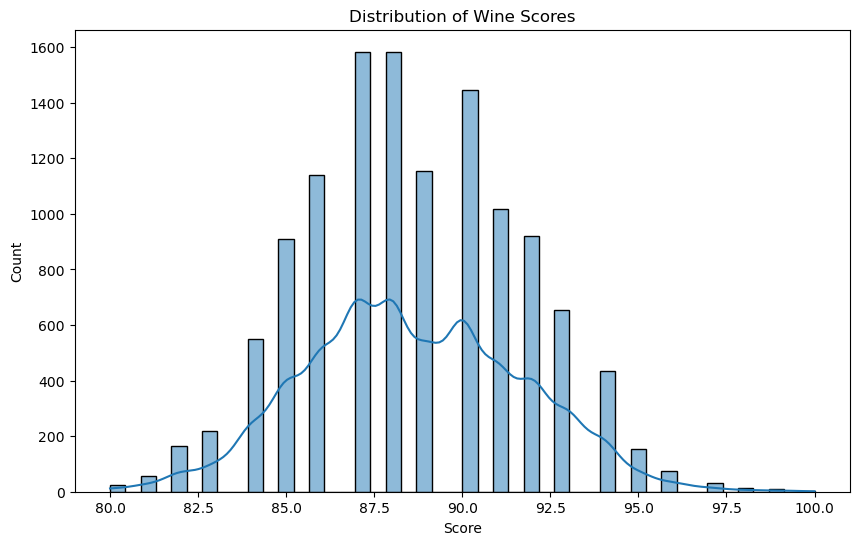

In [68]:
# Histogram of Wine Scores
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], kde=True)
plt.title('Distribution of Wine Scores')
plt.xlabel('Score')
plt.show()

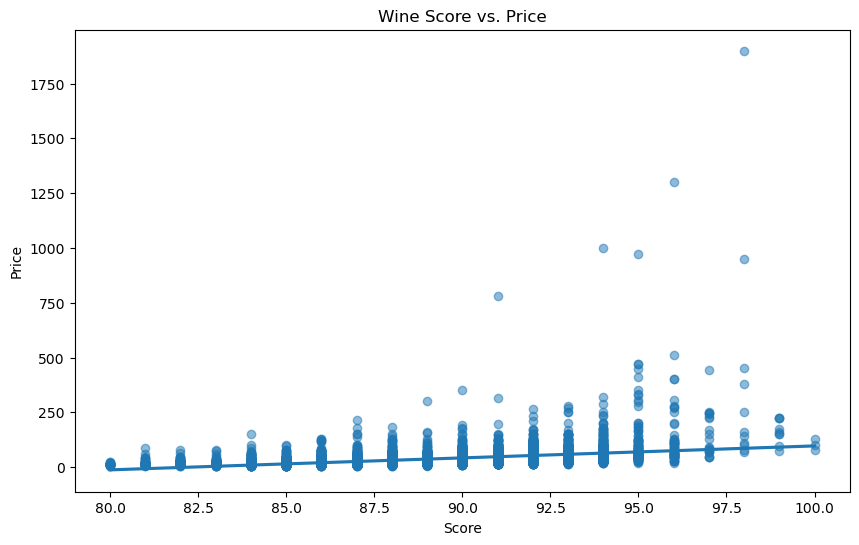

In [69]:
# Scatter plot of Wine Score vs. Price with Trendline
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='score', y='price', scatter_kws={'alpha':0.5})
plt.title('Wine Score vs. Price')
plt.xlabel('Score')
plt.ylabel('Price')
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


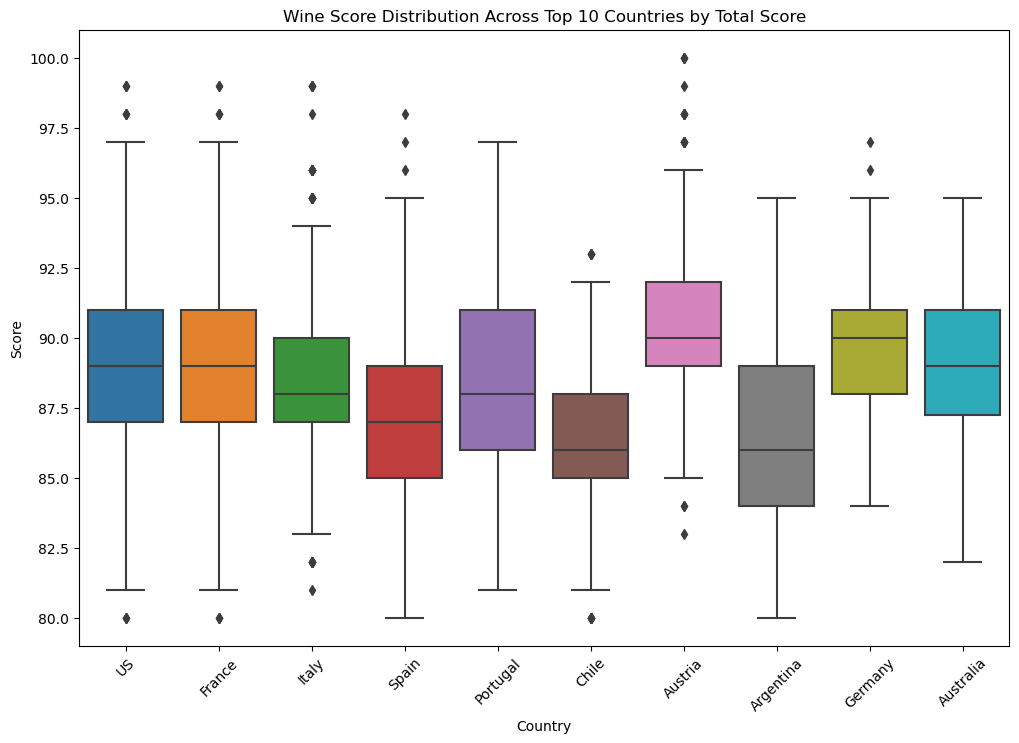

In [70]:
# Calculate total score for each country
country_total_scores = df.groupby('country')['score'].sum().reset_index()

# Determine the top 10 countries based on total wine score
top_10_countries_by_score = country_total_scores.sort_values(by='score', ascending=False).head(10)['country']

# Filter the DataFrame for only the top 10 countries
df_top_countries_by_score = df[df['country'].isin(top_10_countries_by_score)]

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_countries_by_score, x='country', y='score', order=top_10_countries_by_score)
plt.title('Wine Score Distribution Across Top 10 Countries by Total Score')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


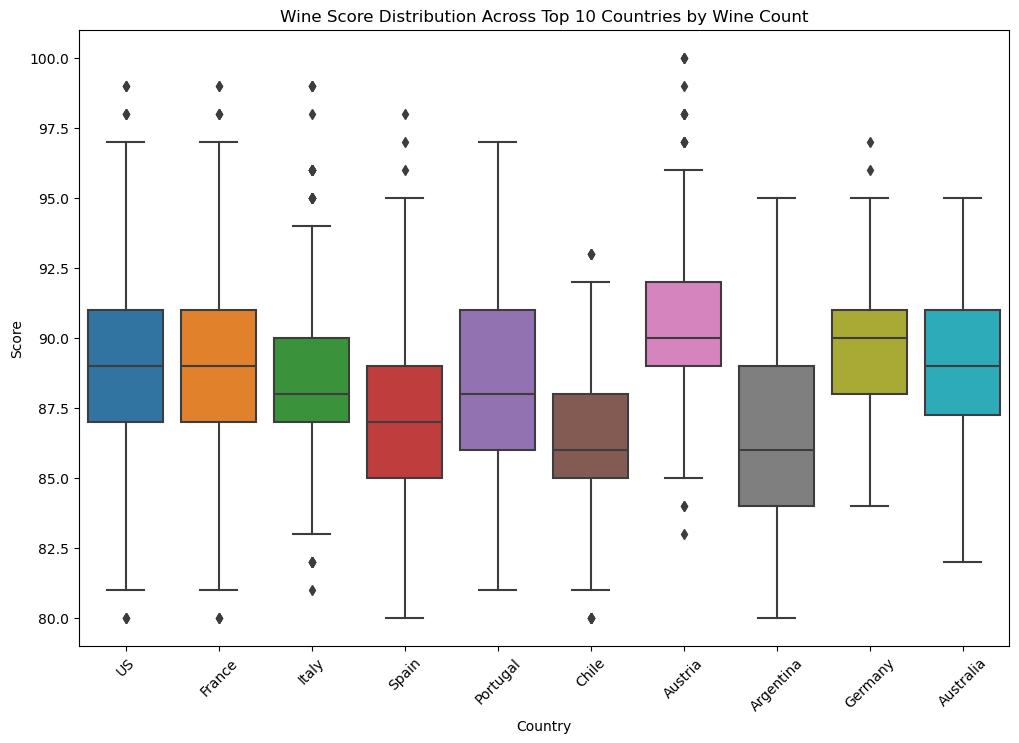

In [71]:
# Calculate the top 10 countries by the number of wines
top_10_countries_by_count = df['country'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only the top 10 countries
df_top_countries_by_count = df[df['country'].isin(top_10_countries_by_count)]

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_countries_by_count, x='country', y='score', order=top_10_countries_by_count)
plt.title('Wine Score Distribution Across Top 10 Countries by Wine Count')
plt.xlabel('Country')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


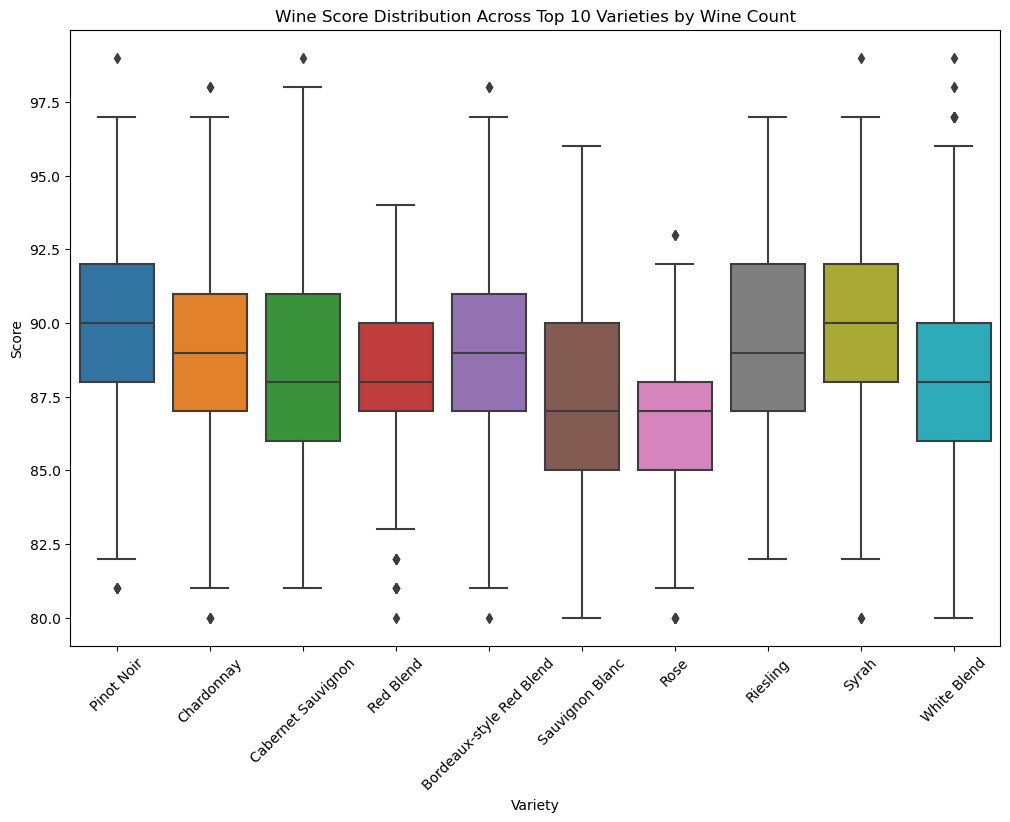

In [72]:
# Calculate the top 10 varieties by wine count
top_10_varieties_by_count = df['variety'].value_counts().head(10).index

# Filter the DataFrame to include only the top 10 varieties by count
df_top_varieties_by_count = df[df['variety'].isin(top_10_varieties_by_count)]

# Create the boxplot for wine count
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_varieties_by_count, x='variety', y='score', order=top_10_varieties_by_count)
plt.title('Wine Score Distribution Across Top 10 Varieties by Wine Count')
plt.xlabel('Variety')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


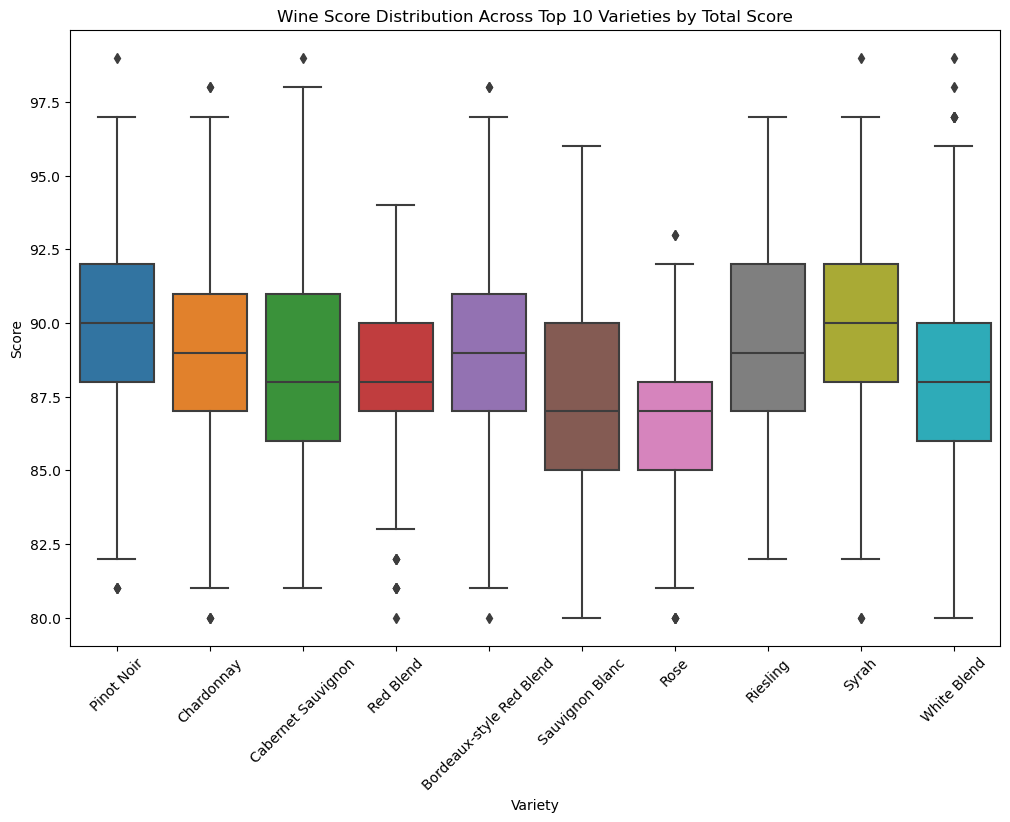

In [73]:
# Calculate the total scores for each variety
sum_scores_by_variety = df.groupby('variety')['score'].sum().sort_values(ascending=False)

# Identify the top 10 varieties based on the sum of scores
top_10_varieties_by_sum_score = sum_scores_by_variety.head(10).index

# Filter the DataFrame to include only the top 10 varieties by sum of scores
df_top_varieties_by_sum_score = df[df['variety'].isin(top_10_varieties_by_sum_score)]

# Create the boxplot for top 10 varieties by sum of score
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_varieties_by_sum_score, x='variety', y='score', order=top_10_varieties_by_sum_score)
plt.title('Wine Score Distribution Across Top 10 Varieties by Total Score')
plt.xlabel('Variety')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


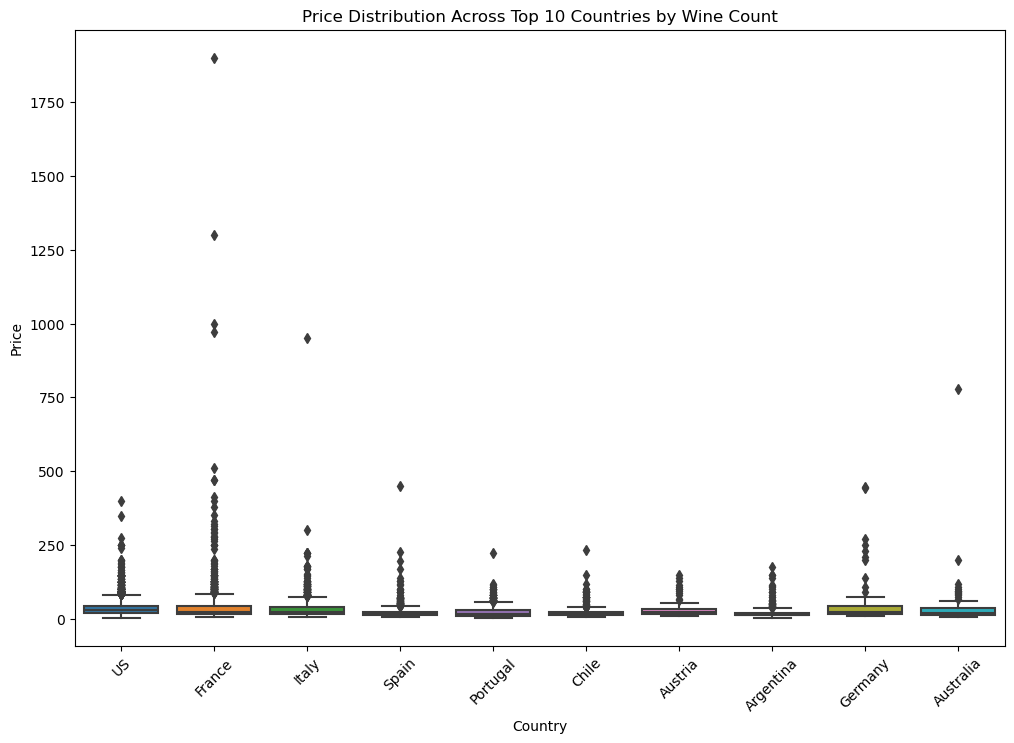

In [74]:
# Top 10 countries by the total number of wines
top_10_countries_by_count = df['country'].value_counts().head(10).index

# Filter the DataFrame for these top 10 countries
df_top_countries_by_count = df[df['country'].isin(top_10_countries_by_count)]

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_countries_by_count, x='country', y='price', order=top_10_countries_by_count)
plt.title('Price Distribution Across Top 10 Countries by Wine Count')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


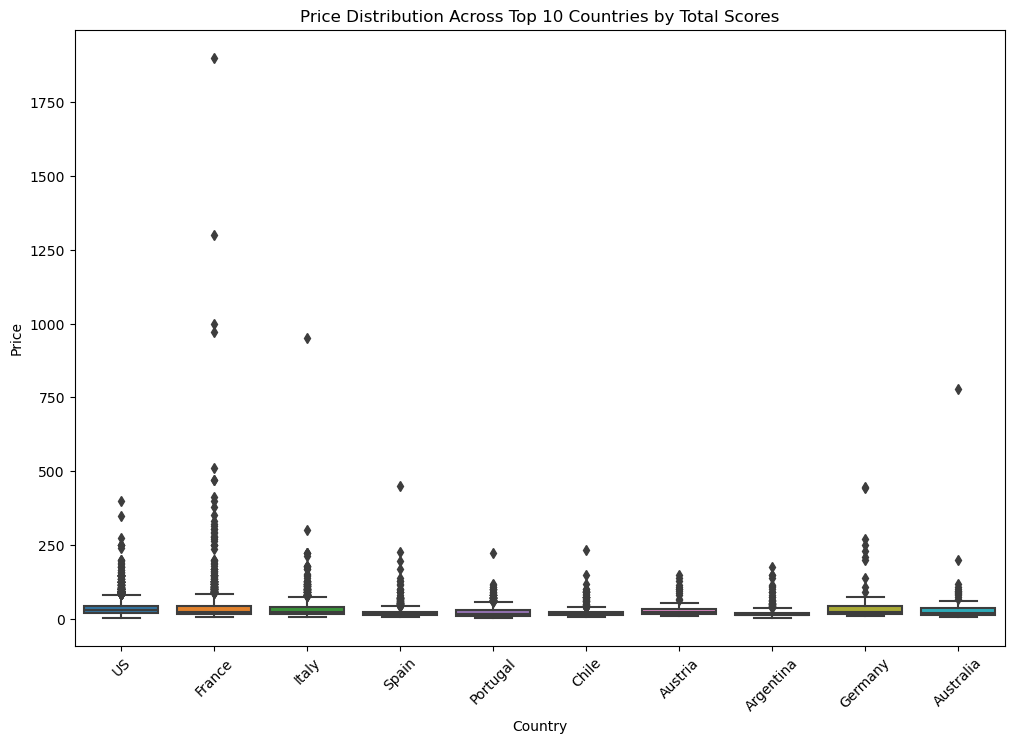

In [75]:
# Calculate the sum of scores for each country
sum_scores_by_country = df.groupby('country')['score'].sum().sort_values(ascending=False)

# Identify the top 10 countries based on the sum of scores
top_10_countries_by_sum_score = sum_scores_by_country.head(10).index

# Filter the DataFrame to include only these top 10 countries
df_top_countries_by_sum_score = df[df['country'].isin(top_10_countries_by_sum_score)]

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_countries_by_sum_score, x='country', y='price', order=top_10_countries_by_sum_score)
plt.title('Price Distribution Across Top 10 Countries by Total Scores')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


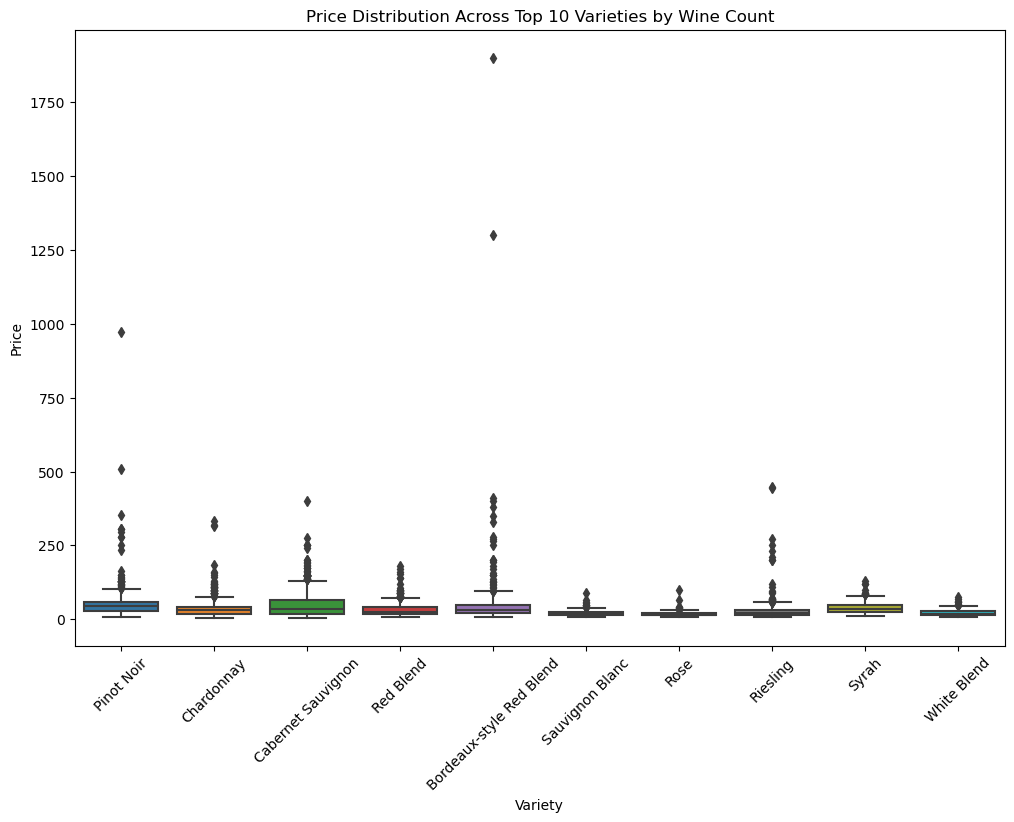

In [76]:
# Top 10 varieties by the total number of wines
top_10_varieties_by_count = df['variety'].value_counts().head(10).index

# Filter the DataFrame for these top 10 varieties
df_top_varieties_by_count = df[df['variety'].isin(top_10_varieties_by_count)]

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_varieties_by_count, x='variety', y='price', order=top_10_varieties_by_count)
plt.title('Price Distribution Across Top 10 Varieties by Wine Count')
plt.xlabel('Variety')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


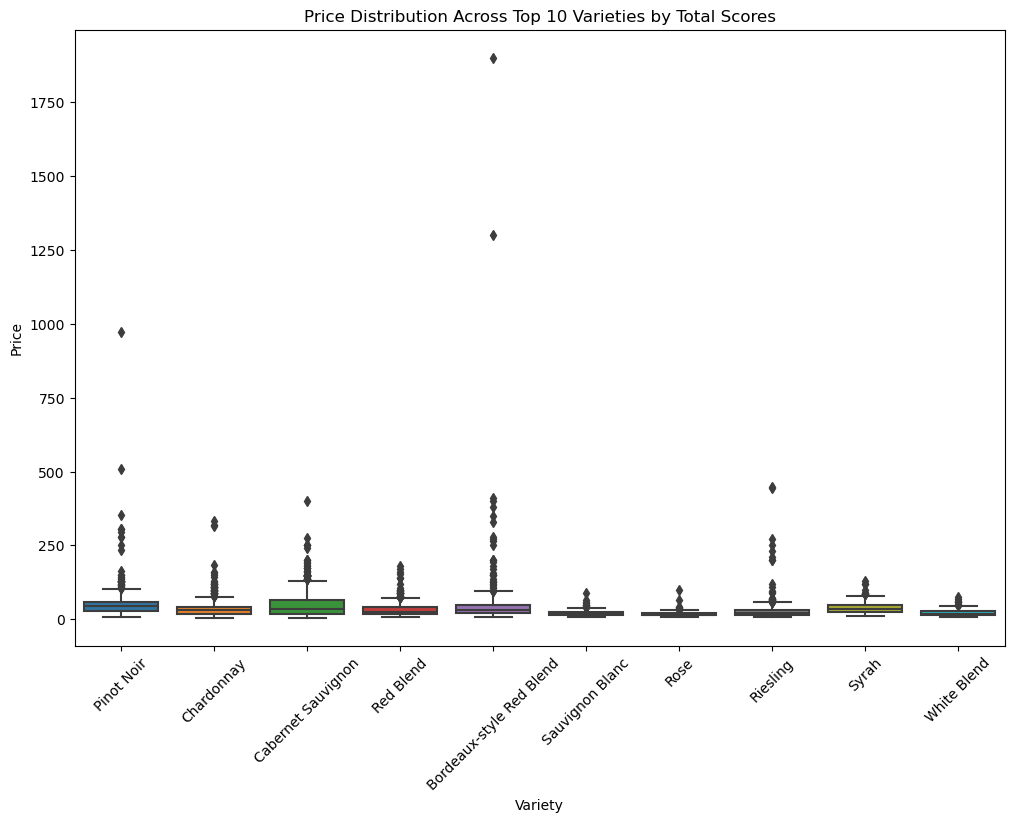

In [77]:
# Calculate the sum of scores for each variety
sum_scores_by_variety = df.groupby('variety')['score'].sum().sort_values(ascending=False)

# Identify the top 10 varieties based on the sum of scores
top_10_varieties_by_sum_score = sum_scores_by_variety.head(10).index

# Filter the DataFrame to include only these top 10 varieties
df_top_varieties_by_sum_score = df[df['variety'].isin(top_10_varieties_by_sum_score)]

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_varieties_by_sum_score, x='variety', y='price', order=top_10_varieties_by_sum_score)
plt.title('Price Distribution Across Top 10 Varieties by Total Scores')
plt.xlabel('Variety')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

After plotting the graphs for the basic exploration, lets dive deeper. It is often said that the more details regarding the production location of the wine on a wine label, it often means higher quality, which in turns suggests higher prices. Lets create a series of graphs to explore that idea.

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


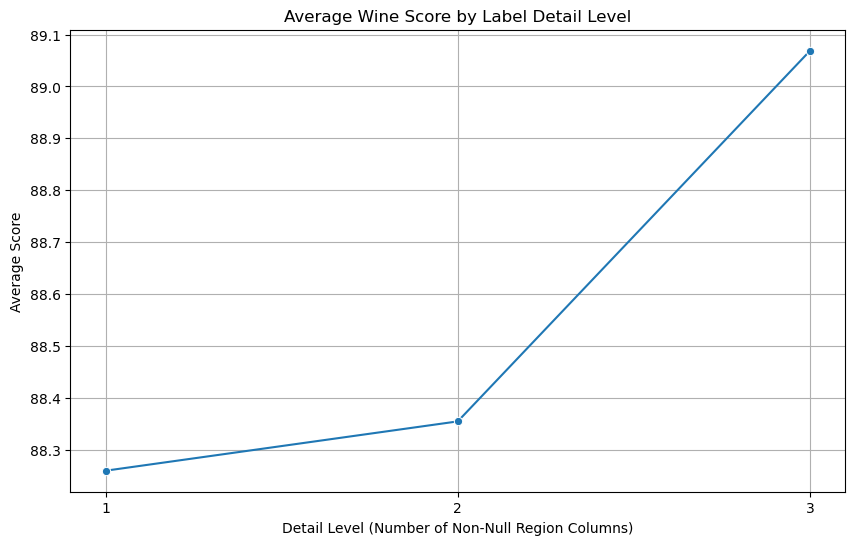

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


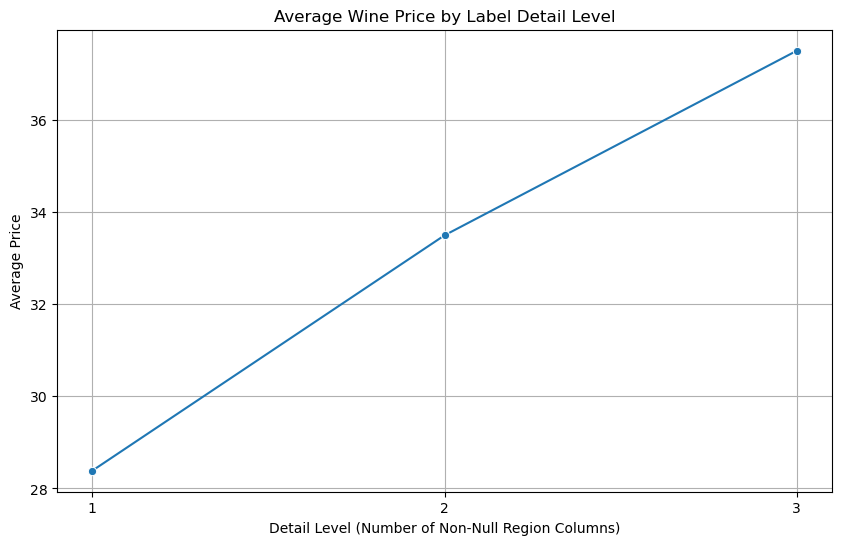

In [78]:
# Create a new column 'Detail_Level' counting non-null values across Region 1, 2, and 3
df['Detail_Level'] = df[['region_1', 'region_2', 'region_3']].notnull().sum(axis=1)

# Group by 'Detail_Level' and calculate the mean for 'Score' and 'Price'
detail_level_stats = df.groupby('Detail_Level').agg({'score': 'mean', 'price': 'mean'}).reset_index()

# Plotting the relationship between Detail Level and Average Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=detail_level_stats, x='Detail_Level', y='score', marker='o')
plt.title('Average Wine Score by Label Detail Level')
plt.xlabel('Detail Level (Number of Non-Null Region Columns)')
plt.ylabel('Average Score')
plt.xticks(detail_level_stats['Detail_Level'])
plt.grid(True)
plt.show()

# Plotting the relationship between Detail Level and Average Price
plt.figure(figsize=(10, 6))
sns.lineplot(data=detail_level_stats, x='Detail_Level', y='price', marker='o')
plt.title('Average Wine Price by Label Detail Level')
plt.xlabel('Detail Level (Number of Non-Null Region Columns)')
plt.ylabel('Average Price')
plt.xticks(detail_level_stats['Detail_Level'])
plt.grid(True)
plt.show()

With the data we have, our hypothesis on the more details on the wine label the higher the quality of wine is correct.

Here is a quick rundown on various insights obtained from the other graphs that were ran so far:

1. **Price Distribution Across Top 10 Varieties & Countries by Total Scores and Wine Count:**
   - The violin and box plots indicate a wide distribution of prices across different varieties and countries. Some varieties, like Bordeaux-style Red Blend and Pinot Noir, show particularly high price points, which might be associated with their market positioning or quality perception.
   - The comparison between distributions by total scores and wine count could imply the popularity and perceived quality of wines, with certain varieties like Pinot Noir and Chardonnay showing a strong presence in both metrics.

2. **Wine Score Distribution Across Top 10 Varieties & Countries by Total Score and Wine Count:**
   - The box plots demonstrate the range of scores that different varieties and countries receive. Some varieties have a wide range of scores (like Pinot Noir), while others, like Syrah, show a tighter clustering, which could indicate consistency in quality.
   - The country-wise score distribution also shows variability, with countries like France and Italy showcasing a wide range of scores, potentially reflecting the diversity of wine types produced.

3. **Wine Score vs. Price & Distribution of Wine Scores:**
   - The scatter plot of wine score versus price shows that higher scores can be associated with higher prices, but there are many affordable wines with high scores as well. The price does not necessarily increase linearly with the score, and there is considerable variability in price among wines with similar scores.
   - The histogram of wine scores indicates that the majority of wines have scores clustered around specific intervals, with fewer wines achieving scores at the extreme high end. The score distribution is seemingly normal with a concentration in the mid-range scores, suggesting that exceptionally high or low scores are less common.

#### Summary of Insights so far
- Detailed labeling seems to be associated with higher quality and price.
- There is significant variability in wine prices across different varieties and countries, with certain varieties commanding higher prices.
- Wine scores vary widely among top varieties and countries, but most wines have mid-range scores.
- While there is a trend of higher prices for higher-scoring wines, there is a substantial number of reasonably priced wines with high scores, indicating that quality is accessible at various price points.
- Wine score distributions suggest that most wines perform moderately well in scoring, with fewer outliers at the high and low ends.

Now we will explore the relationship between wine score and different aspects of wine and weather data.

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\1243636963.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes_flat[i], data=filtered_data, x='Cycle', y='Average', hue='Variety', ci=None)
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:

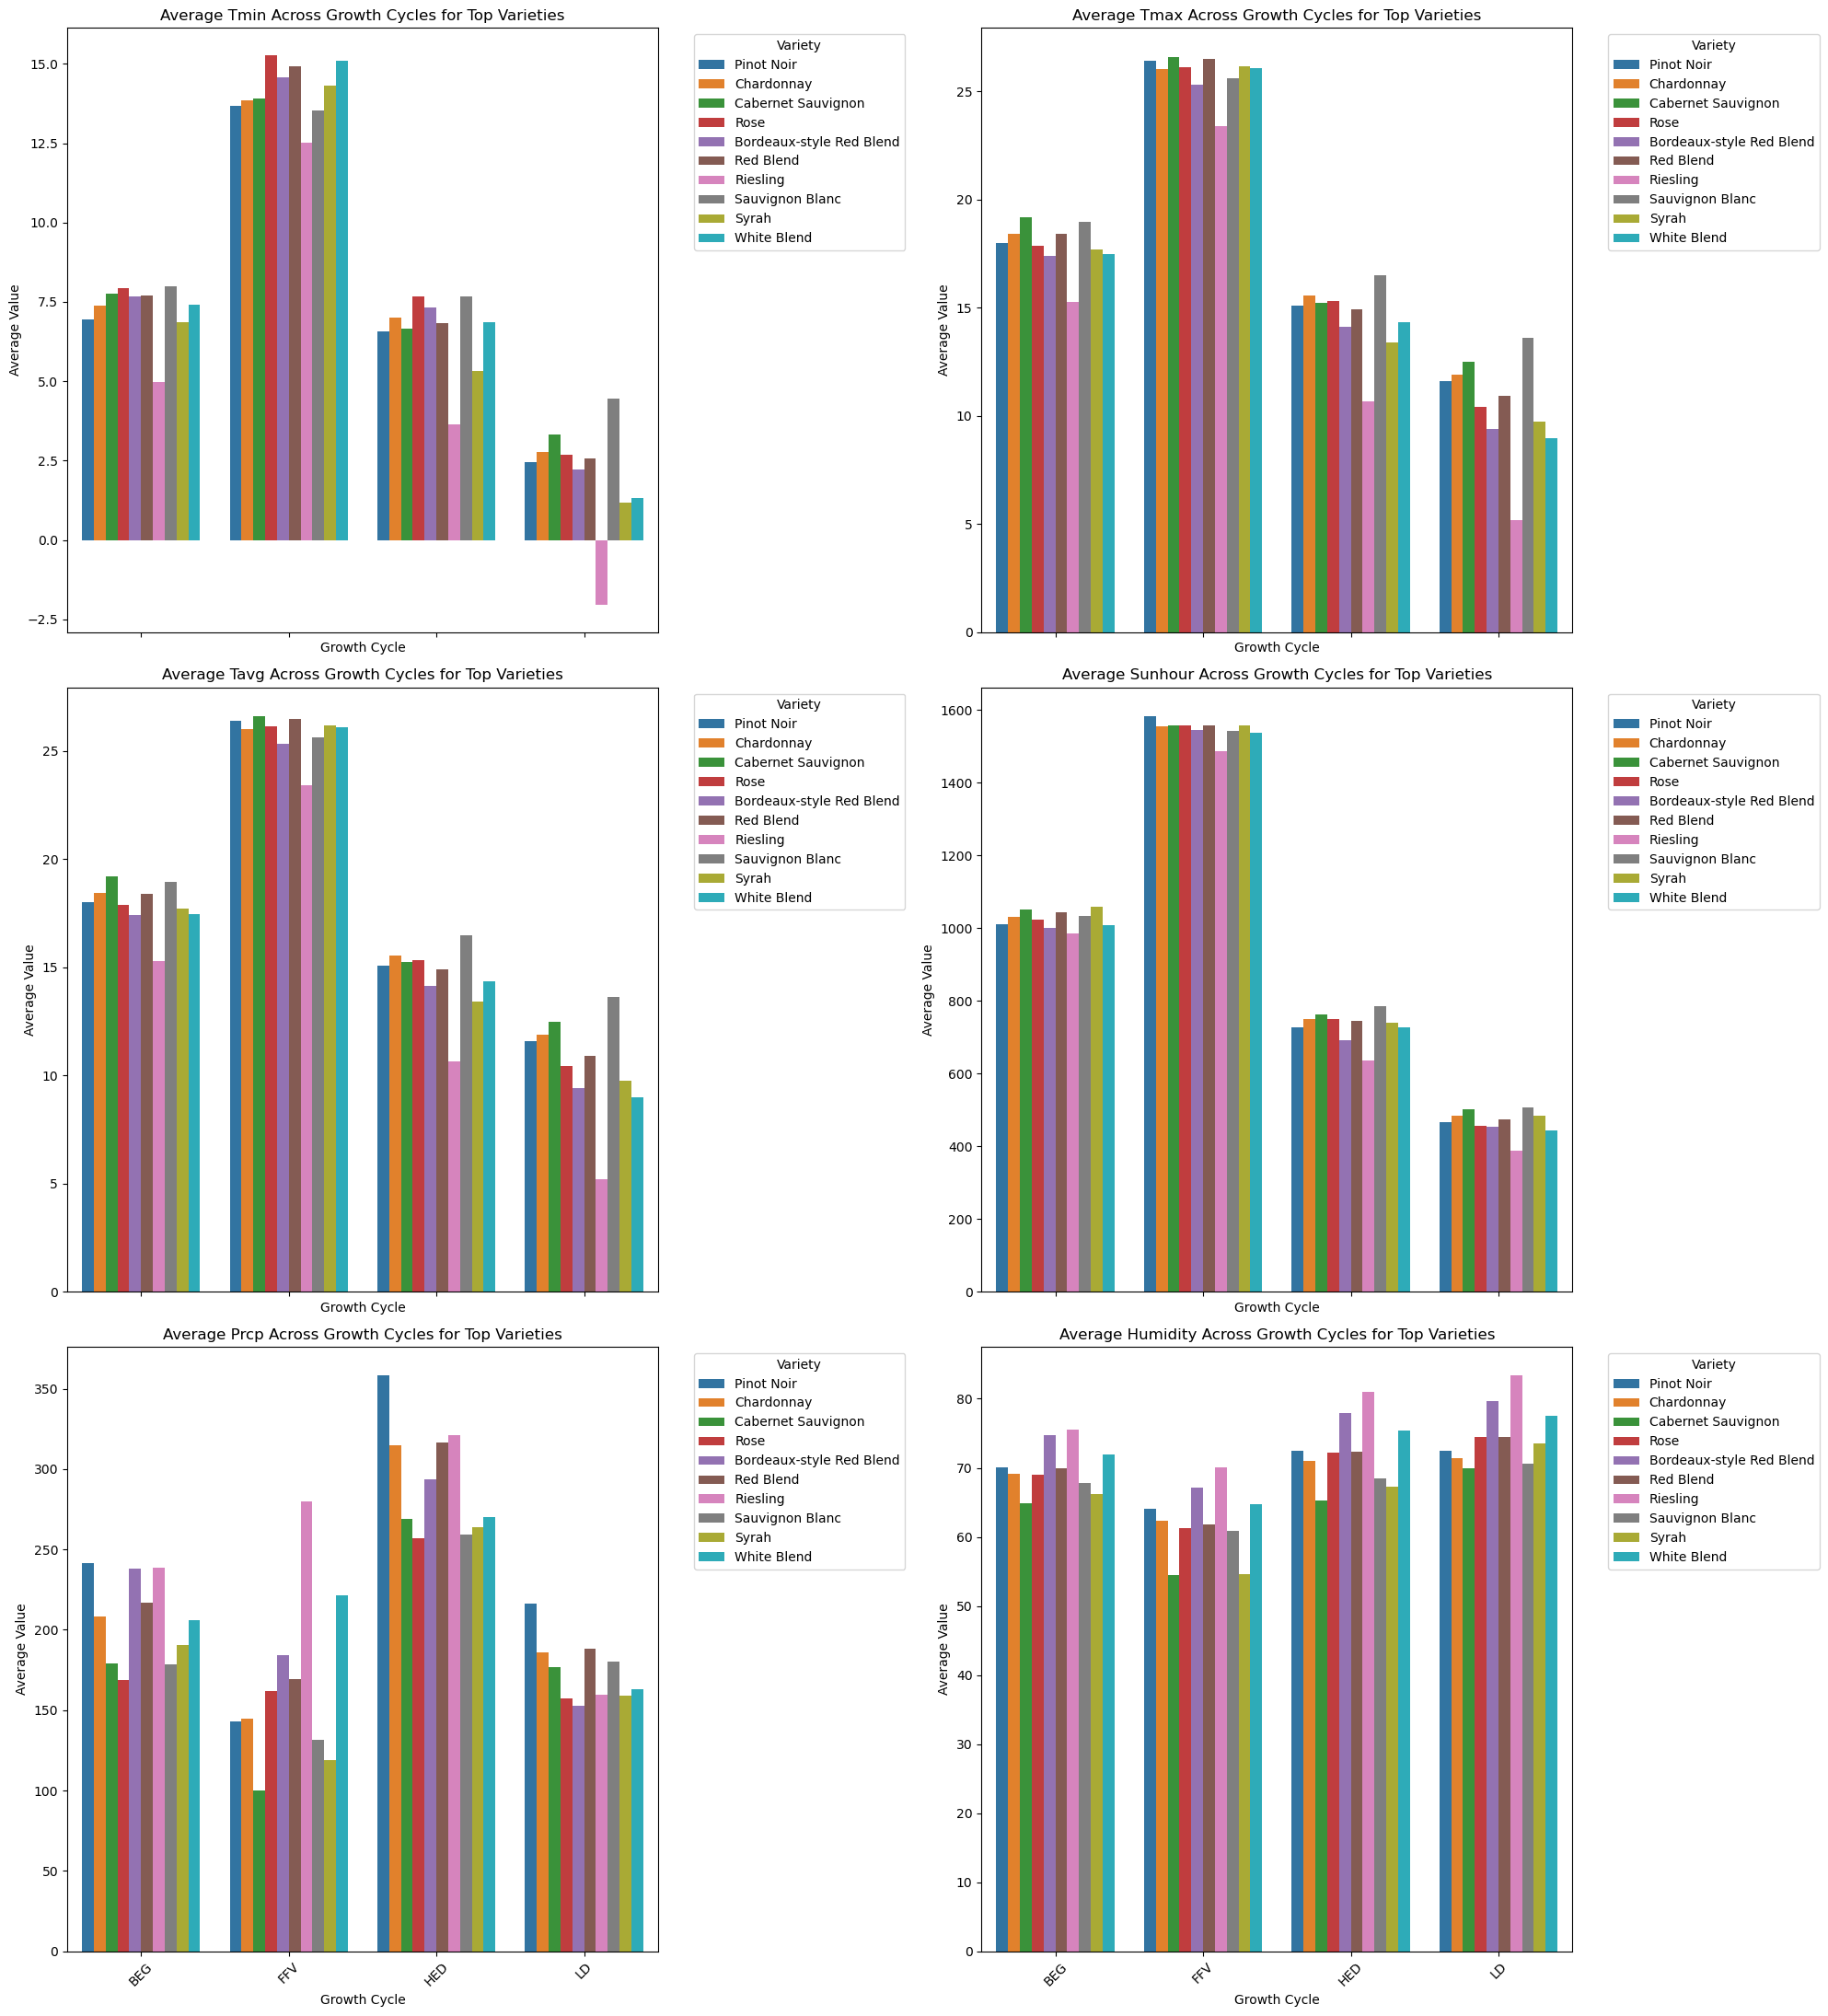

In [79]:
# Top 10 varieties based on your criteria
top_varieties = ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Rose', 
                 'Bordeaux-style Red Blend', 'Red Blend', 'Riesling', 
                 'Sauvignon Blanc', 'Syrah', 'White Blend']

# Weather data types and growth cycles based on the new schema
weather_data_types = ['tmin', 'tmax', 'tavg', 'sunhour', 'prcp', 'humidity']
cycles = ['BEG', 'FFV', 'HED', 'LD']

# Filter DataFrame for top varieties
df_top_varieties = df[df['variety'].isin(top_varieties)]

# Calculating average weather data for Top Varieties
average_weather_data_top_varieties = {}
for variety in top_varieties:
    for cycle in cycles:
        for weather_type in weather_data_types:
            # Identify columns matching the current cycle and weather type
            cycle_weather_cols = [col for col in df_top_varieties.columns if col.endswith(f'_{cycle}') and col.startswith(weather_type)]
            # Calculate the average across the selected columns for the current variety
            avg_per_variety_cycle = df_top_varieties.loc[df_top_varieties['variety'] == variety, cycle_weather_cols].mean(axis=1).mean()
            average_weather_data_top_varieties[(variety, cycle, weather_type)] = avg_per_variety_cycle

# Convert to DataFrame
average_weather_df = pd.DataFrame(list(average_weather_data_top_varieties.items()), columns=['Variety_Cycle_Type', 'Average'])
average_weather_df[['Variety', 'Cycle', 'Weather_Type']] = pd.DataFrame(average_weather_df['Variety_Cycle_Type'].tolist(), index=average_weather_df.index)
average_weather_df.drop(columns=['Variety_Cycle_Type'], inplace=True)

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(20, 22), sharex=True)
axes_flat = axes.flatten()

for i, weather_type in enumerate(weather_data_types):
    filtered_data = average_weather_df[average_weather_df['Weather_Type'] == weather_type]
    sns.barplot(ax=axes_flat[i], data=filtered_data, x='Cycle', y='Average', hue='Variety', ci=None)
    axes_flat[i].set_title(f'Average {weather_type.capitalize()} Across Growth Cycles for Top Varieties')
    axes_flat[i].set_xlabel('Growth Cycle')
    axes_flat[i].set_ylabel('Average Value')
    axes_flat[i].tick_params(axis='x', rotation=45)
    axes_flat[i].legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\2106680583.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_weather_data = df.groupby('score_bin')[col_name].mean()


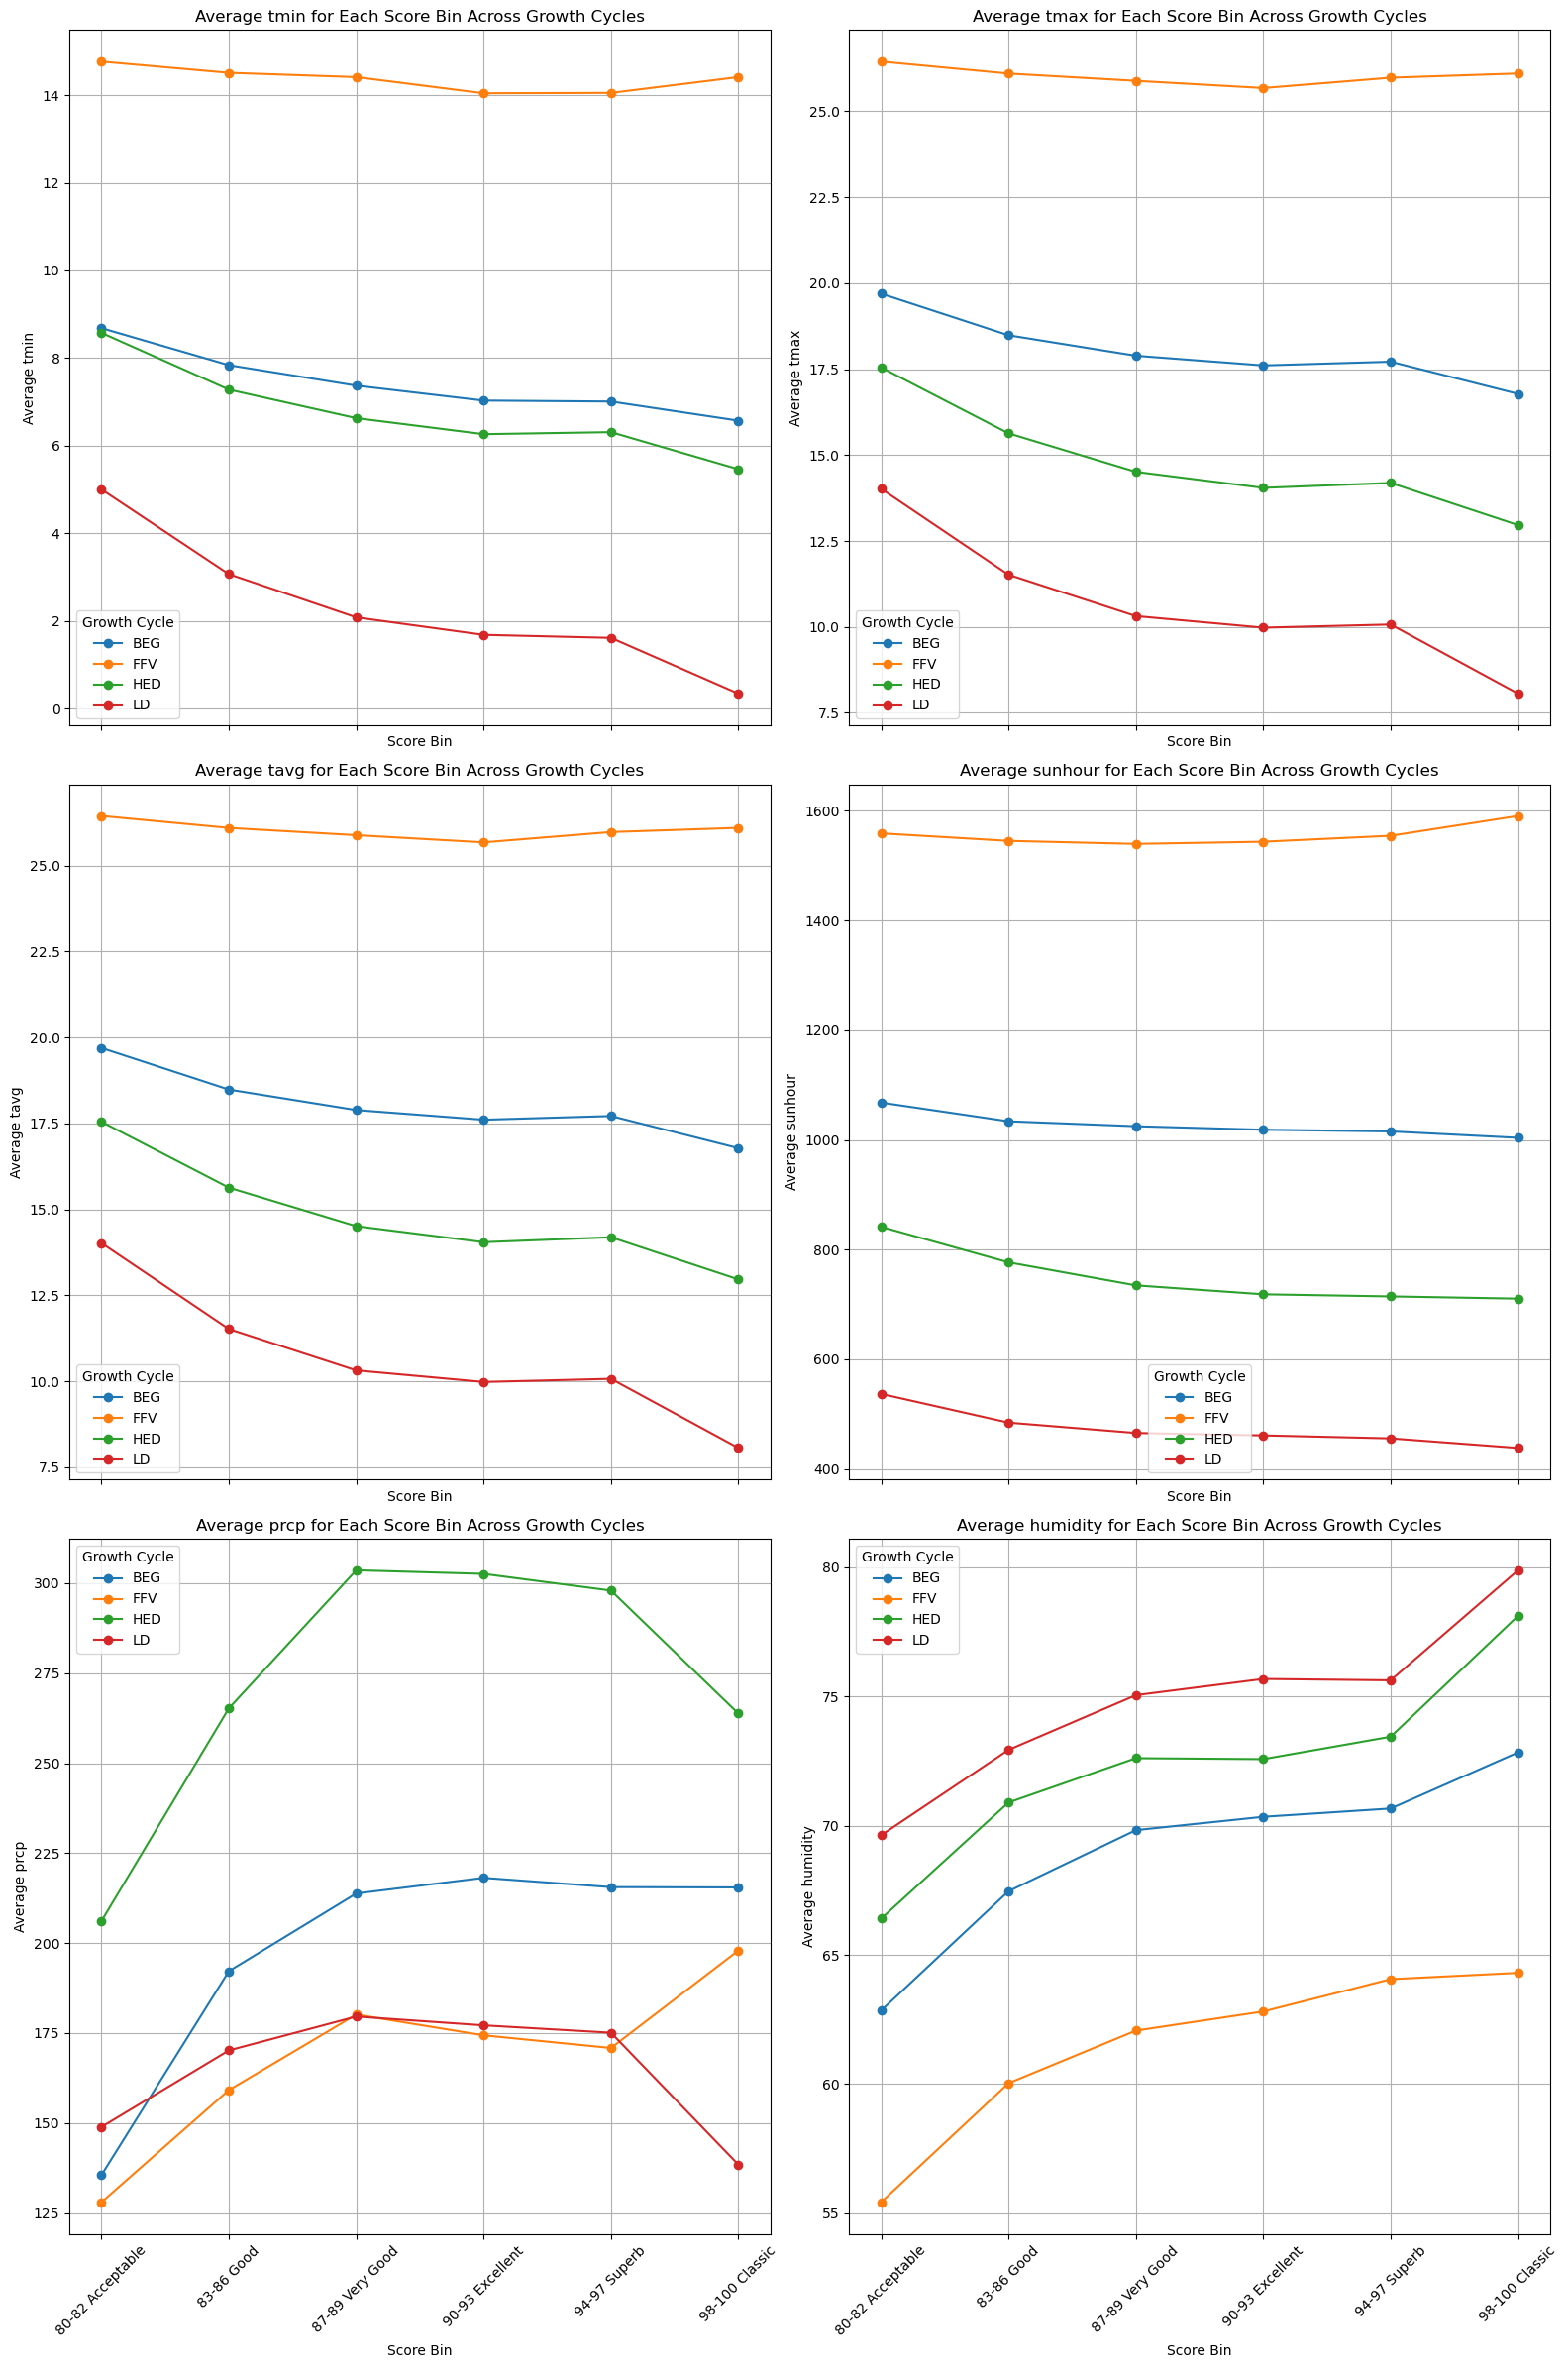

In [80]:
# Define score bins and labels
score_bins = [80, 82, 86, 89, 93, 97, 100]
bin_labels = ['80-82 Acceptable', '83-86 Good', '87-89 Very Good', 
              '90-93 Excellent', '94-97 Superb', '98-100 Classic']

df['score_bin'] = pd.cut(df['score'], bins=score_bins, labels=bin_labels, right=False)

# Calculate the average weather data for each bin
avg_weather_data_per_bin = {}
for weather_type in ['tmin', 'tmax', 'tavg', 'sunhour', 'prcp', 'humidity']:
    for cycle in ['BEG', 'FFV', 'HED', 'LD']:
        col_name = f'{weather_type}_{cycle}'
        avg_weather_data = df.groupby('score_bin')[col_name].mean()
        avg_weather_data_per_bin[col_name] = avg_weather_data

# Convert to DataFrame
avg_weather_df = pd.DataFrame(avg_weather_data_per_bin)

# Plotting a matrix of line plots for each weather data type in a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(16, 24), sharex=True)

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate through each weather data type
for i, weather_type in enumerate(['tmin', 'tmax', 'tavg', 'sunhour', 'prcp', 'humidity']):
    for cycle in ['BEG', 'FFV', 'HED', 'LD']:
        col_name = f'{weather_type}_{cycle}'
        axes_flat[i].plot(avg_weather_df.index, avg_weather_df[col_name], marker='o', label=cycle)

    axes_flat[i].set_title(f'Average {weather_type} for Each Score Bin Across Growth Cycles')
    axes_flat[i].set_xlabel('Score Bin')
    axes_flat[i].set_ylabel(f'Average {weather_type}')
    axes_flat[i].legend(title='Growth Cycle')
    axes_flat[i].grid(True)
    axes_flat[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Since we want to specifically look at grape varietals not wine varieties we need to remove blends or non grape specific wine varieties from the top wine list for our exploration. Also since we want to look at what makes a wine good, we will only be looking at the wines that scored 90 and above.

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-pa

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-pa

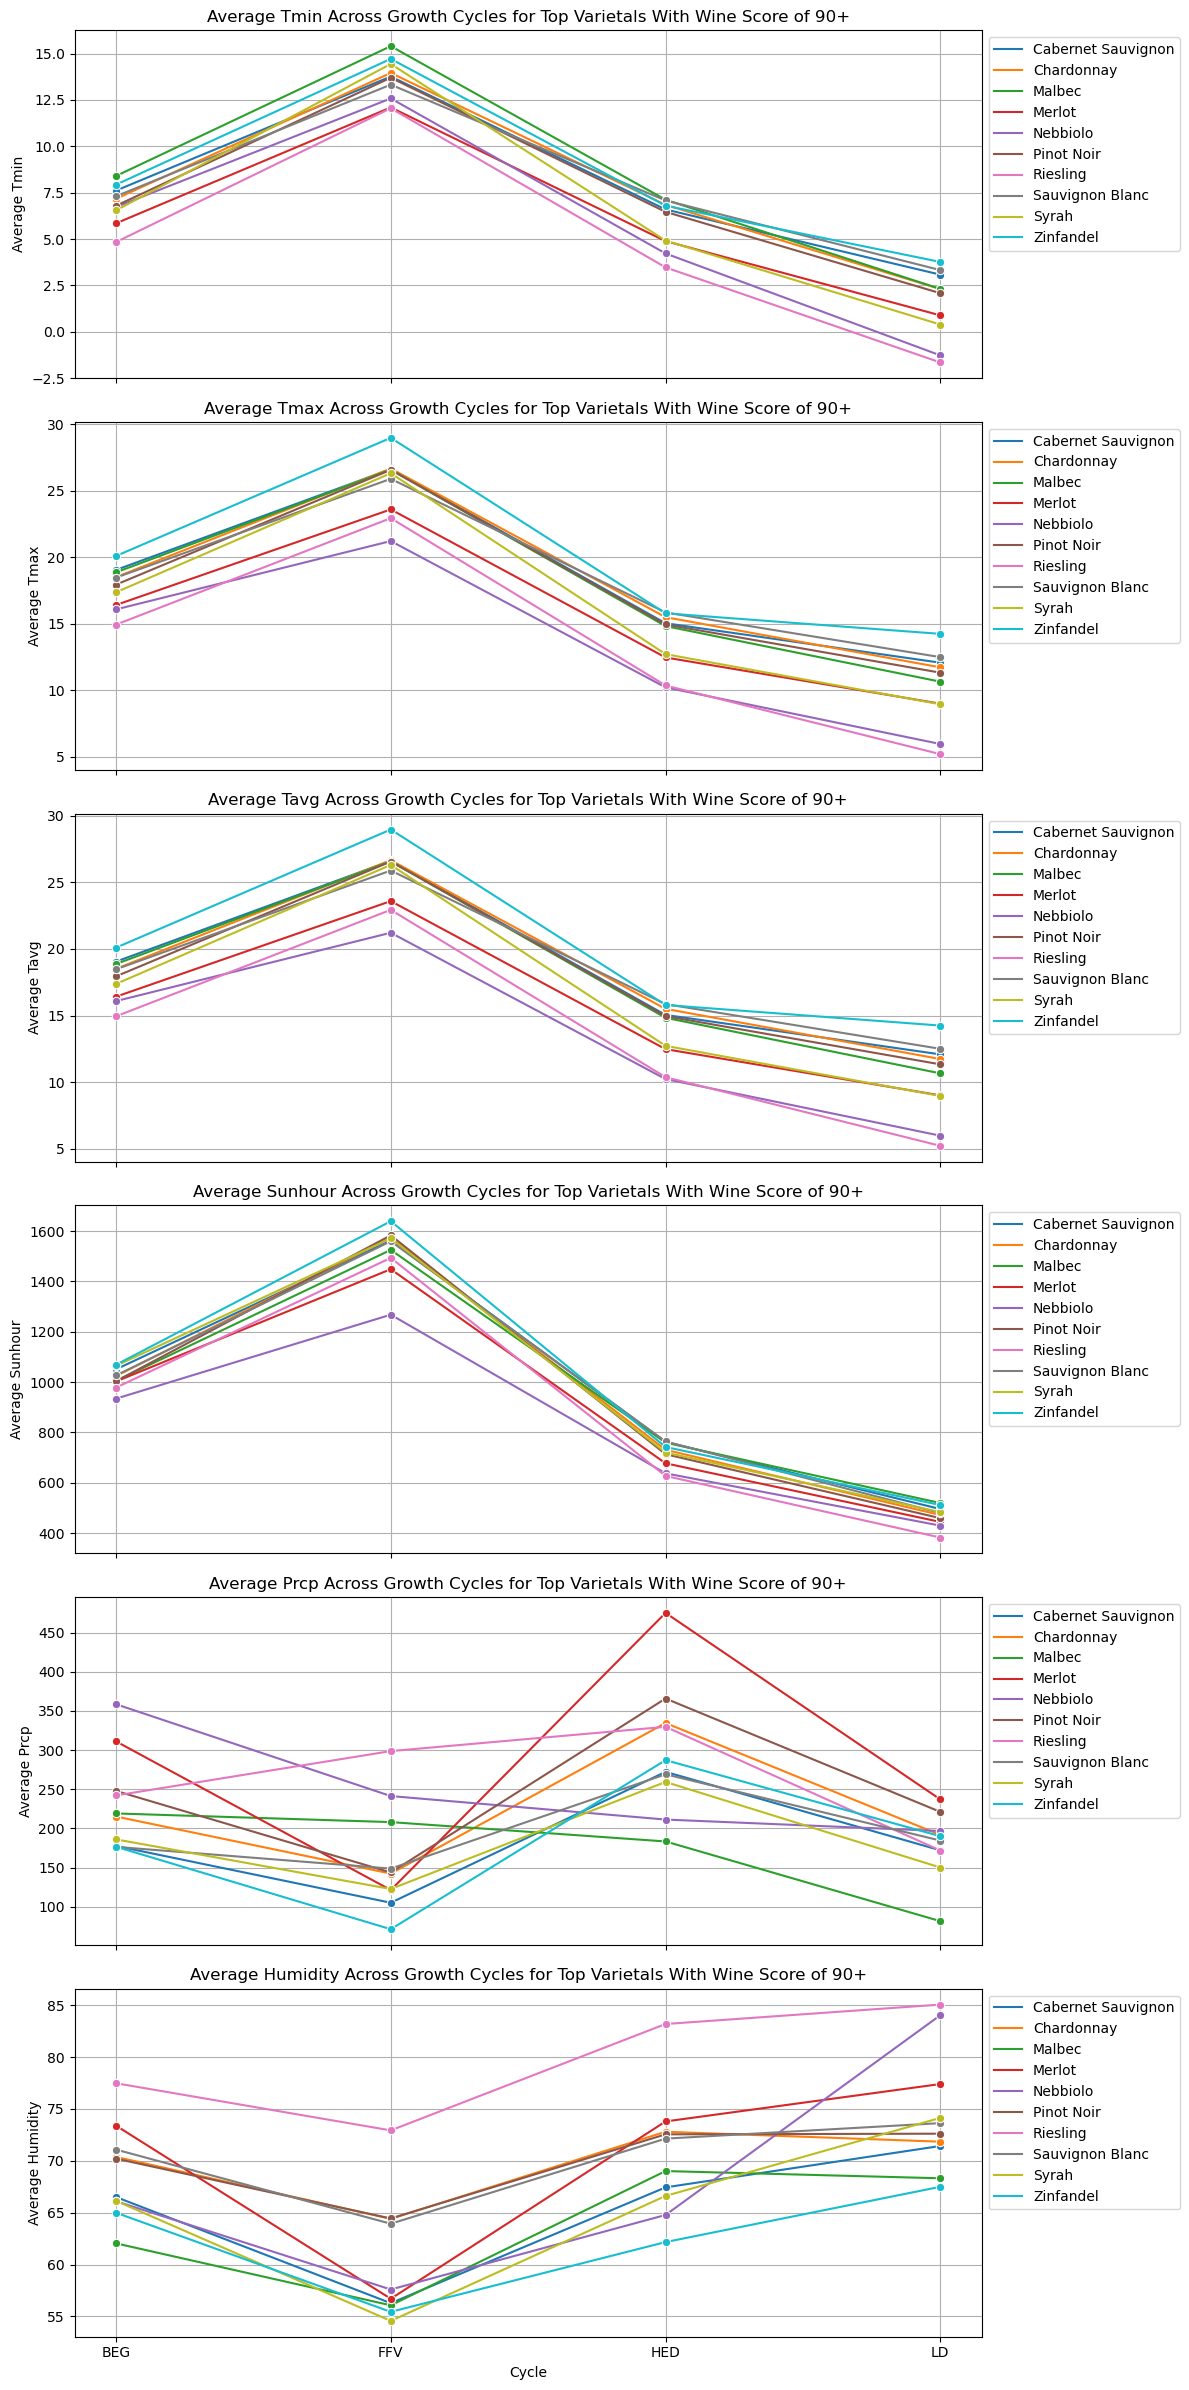

In [81]:
# Varities to Exlude
excluded_varieties = ['Blend', 'Rose', 'Portuguese Red']

# Step 1: Identify top 10 varieties based on sum of score and count of wines, excluding specified varieties
score_sum_top_varieties = df[df['variety'].str.contains('|'.join(excluded_varieties), na=False) == False].groupby('variety')['score'].sum().nlargest(10)
count_top_varieties = df[df['variety'].str.contains('|'.join(excluded_varieties), na=False) == False]['variety'].value_counts().head(10)

# Combining the lists from the two metrics and dropping duplicates
top_varieties_combined = pd.Index(score_sum_top_varieties.index.union(count_top_varieties.index))

# This list is now known as top grape varietals
top_grape_varietals = top_varieties_combined

# Step 3: Filter the dataset for wines of these top varieties with a wine score of 90 or higher
df_filtered = df[df['variety'].isin(top_grape_varietals) & (df['score'] >= 90)]

# Step 4: Graph by comparing each varietal across growth cycles to the average of each weather datatype
# Calculate average weather data for each varietal and cycle
avg_weather_data = {}
for varietal in top_grape_varietals:
    for cycle in cycles:
        for weather_type in weather_data_types:
            col_name = f'{weather_type}_{cycle}'
            avg_data = df_filtered[df_filtered['variety'] == varietal][col_name].mean()
            avg_weather_data[(varietal, cycle, weather_type)] = avg_data

# Convert the dictionary to a DataFrame for easier manipulation
avg_weather_df = pd.DataFrame(list(avg_weather_data.items()), columns=['Varietal_Cycle_Type', 'Average'])
avg_weather_df[['Varietal', 'Cycle', 'Weather_Type']] = pd.DataFrame(avg_weather_df['Varietal_Cycle_Type'].tolist(), index=avg_weather_df.index)
avg_weather_df.drop(columns=['Varietal_Cycle_Type'], inplace=True)

# Pivot for visualization
pivot_df = avg_weather_df.pivot_table(index=['Varietal', 'Cycle'], columns='Weather_Type', values='Average').reset_index()

# Plotting with adjusted layout to prevent legend from blocking the chart
fig, axes = plt.subplots(len(weather_data_types), 1, figsize=(12, 24), sharex=True)

for i, weather_type in enumerate(weather_data_types):
    sns.lineplot(ax=axes[i], data=pivot_df, x='Cycle', y=weather_type, hue='Varietal', marker='o')
    axes[i].set_title(f'Average {weather_type.capitalize()} Across Growth Cycles for Top Varietals With Wine Score of 90+')
    axes[i].set_ylabel(f'Average {weather_type.capitalize()}')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

The aforementioned visualizations showing different weather data types with different wine varities and wine scores tells us the following:

- High scoring wines have ample amount of rain during BEG and FFV and tends to have the least amount of rain during LD and HED.
- Tempure for high quality wines during FFV tends to go the not too hot but not to cold route, but tends to have the lowest temperatures in all other cycles. The same could be said for sun exposure as well.
- When looking at specific wine varieties, Malbec, Zinfandel, and Syrah of high quality tends to prefer hotter temperatures. While Riesling, Nebbiolo, and Merlot prefer cooler ones.
- Amount of sun exposure seems to line up with how much the grape likes heat.
- There doesn't seem to be a pattern with rain fall for each variety, but it does seem like the high quality ones do not like rain when they are in dormat stages outside of early dormancy or right before harvest. The only variety that seems to have a pattern is Malbec where it's rain fall decreases steady across each growth stage.
- Humidity seems to be all over the place too, with Riesling being able to withstand high humidity the most. However this is most likely because Riseling have many different styles and one of the most expensive styles is late harvest, which incurages Botrytis, a type of grape fungal growth, that requires high humidity right before sunrise and enough heat to dry off the dew quickly during the rest of the day.


### Preliminary Statistical Analysis

In [84]:
# Load the dataset
df = pd.read_csv('data/clean/combined_weather_enhanced_wine_data_with_Hemisphere_and_cycles.csv')

# Define score bins and labels
score_bins = [0, 85, 90, 95, 100]
score_labels = ['Below 85', '85-89 Average', '90-94 Good', '95-100 Excellent']
df['score_bin'] = pd.cut(df['score'], bins=score_bins, labels=score_labels, include_lowest=True)

# Weather data types and growth cycles
weather_data_types = ['tmin', 'tmax', 'tavg', 'sunhour', 'prcp', 'humidity']
cycles = ['BEG', 'FFV', 'HED', 'LD']

# Prepare a dictionary to collect the analysis results
analysis_results = {}

# Perform the statistical analysis for each weather data type and cycle
for weather_type in weather_data_types:
    for cycle in cycles:
        col_name = f'{weather_type}_{cycle}'
        # Group by score_bin and calculate descriptive statistics
        descriptive_stats = df.groupby('score_bin')[col_name].describe()
        # Perform ANOVA to check for significant differences among score bins
        anova_results = stats.f_oneway(
            df[df['score_bin'] == 'Below 85'][col_name].dropna(),
            df[df['score_bin'] == '85-89 Average'][col_name].dropna(),
            df[df['score_bin'] == '90-94 Good'][col_name].dropna(),
            df[df['score_bin'] == '95-100 Excellent'][col_name].dropna()
        )
        # Store the results
        analysis_results[(weather_type, cycle)] = {
            'descriptive_stats': descriptive_stats,
            'anova': anova_results
        }

# Loop through the results for each weather data type and cycle and print the analysis
for (weather_type, cycle), results in analysis_results.items():
    print(f"Weather Type: {weather_type}, Cycle: {cycle}")
    print("Descriptive Statistics:")
    print(results['descriptive_stats'])
    print("\nANOVA Results:")
    print(f"F-statistic: {results['anova'].statistic}, p-value: {results['anova'].pvalue}\n")
    print("-" * 80)

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3120520578.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3120520578.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3120520578.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

Weather Type: tmin, Cycle: BEG
Descriptive Statistics:
                   count      mean       std       min       25%       50%  \
score_bin                                                                    
Below 85          1921.0  7.875872  3.234666 -5.967025  6.233333  7.990323   
85-89 Average     6907.0  7.241926  3.272265 -7.270251  5.253405  7.259140   
90-94 Good        3177.0  7.044016  3.336569 -5.659857  5.253405  6.972043   
95-100 Excellent   134.0  6.364891  2.462319 -4.826165  5.124910  6.683692   

                       75%        max  
score_bin                              
Below 85          9.417921  26.354480  
85-89 Average     8.891398  26.559498  
90-94 Good        8.602151  26.335842  
95-100 Excellent  7.990323  15.680645  

ANOVA Results:
F-statistic: 30.484013287416627, p-value: 1.2632901520188879e-19

--------------------------------------------------------------------------------
Weather Type: tmin, Cycle: FFV
Descriptive Statistics:
                  

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3120520578.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3120520578.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df.groupby('score_bin')[col_name].describe()


- **Temperature Minimum (tmin)**: For all cycles (BEG, FFV, HED, LD), there's a statistically significant difference in minimum temperatures when comparing different score bins. This suggests that temperature lows may play a role in wine quality, with cooler temperatures potentially associated with lower scores. However, it's interesting to note that the differences in mean temperatures are not large, indicating that while statistically significant, the practical implications may be subtle.

- **Temperature Maximum (tmax)**: The maximum temperatures show a similar trend with significant differences across score bins. For BEG and HED cycles, the highest temperature maxima are associated with the 'Below 85' score bin, while for LD, the lowest maxima are observed in the '95-100 Excellent' bin, indicating that too much heat isn't necessarily beneficial for the highest quality wines.

- **Temperature Average (tavg)**: Similar to tmin and tmax, the average temperature also shows a statistically significant difference across score bins for all cycles. Lower average temperatures appear to correspond to higher scores, particularly in the BEG cycle.

- **Sun Hours (sunhour)**: More sun hours are associated with higher wine scores, especially during the FFV cycle, which is critical for grape development. This aligns with expectations as ample sunlight is essential for the growth and ripening of grapes.

- **Precipitation (prcp)**: The amount of precipitation shows significant differences across score bins for all cycles. Notably, the highest quality wines ('95-100 Excellent') do not necessarily receive the least or the most rainfall, suggesting a balanced amount of precipitation might be key.

- **Humidity (humidity)**: Higher humidity levels tend to correspond with lower wine scores across all cycles except LD, where the '95-100 Excellent' score bin has the highest mean humidity. This suggests that while a certain level of humidity is necessary, too much can be detrimental to wine quality, possibly due to increased disease pressure.

Now lets include wine variety into the picture.

In [86]:
# Define score bins and labels
score_bins = [0, 85, 90, 95, 100]
score_labels = ['Below 85', '85-89 Average', '90-94 Good', '95-100 Excellent']
df['score_bin'] = pd.cut(df['score'], bins=score_bins, labels=score_labels, include_lowest=True)

# Weather data types and growth cycles
weather_data_types = ['tmin', 'tmax', 'tavg', 'sunhour', 'prcp', 'humidity']
cycles = ['BEG', 'FFV', 'HED', 'LD']

# Prepare a dictionary to collect the analysis results
analysis_results = {}

# Get the list of varieties to be considered in the analysis
varieties = df['variety'].dropna().unique()

# Perform the statistical analysis for each weather data type, cycle, and variety
for variety in varieties:
    # Filter the dataframe for the current variety
    df_variety = df[df['variety'] == variety]
    
    # Skip varieties with count of 9 wines or less
    if df_variety.shape[0] <= 9:
        continue
    
    for weather_type in weather_data_types:
        for cycle in cycles:
            col_name = f'{weather_type}_{cycle}'
            
            # Skip if the column has null values
            if df_variety[col_name].isnull().any():
                continue
            
            # Group by score_bin and calculate descriptive statistics
            descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()

            # Check if there are enough samples for ANOVA
            if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
                # Perform ANOVA to check for significant differences among score bins for this variety
                anova_results = stats.f_oneway(
                    *[group.dropna() for name, group in df_variety.groupby('score_bin')[col_name]]
                )
                
                # Skip if F-statistic or p-value is NaN
                if pd.isna(anova_results.statistic) or pd.isna(anova_results.pvalue):
                    continue

                # Store the results
                analysis_results[(variety, weather_type, cycle)] = {
                    'descriptive_stats': descriptive_stats,
                    'anova': anova_results
                }
            else:
                # Skip this group since it doesn't have enough samples
                continue

# Output the results
for key, result in analysis_results.items():
    variety, weather_type, cycle = key
    print(f"Variety: {variety}, Weather Type: {weather_type}, Cycle: {cycle}")
    print("Descriptive Statistics:")
    print(result['descriptive_stats'])
    print("ANOVA Results:")
    print(f"F-statistic: {result['anova'].statistic}, p-value: {result['anova'].pvalue}")
    print("-" * 80)

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group.dropna() for name, group in df_variety.groupby('score_bin')[col_name]]
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group.dropna() for name, group in df_variety.groupby('score_bin')[col_name]]
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group.dropna() for name, group in df_variety.groupby('score_bin')[col_name]]
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group.dropna() for name, group in df_variety.groupby('score_bin')[col_name]]
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group.dropna() for name, group in df_variety.groupby('score_bin')[col_name]]
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group.dropna() for name, group in df_variety.groupby('score_bin')[col_name]]
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if all(df_variety.groupby('score_bin')[col_name].count().values >= 9):
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = df_variety.groupby('score_bin')[col_name].describe()
C:\Users\George Jieh\AppData\Local\Temp\ipykernel_25472\3266020345.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

Variety: White Blend, Weather Type: tmin, Cycle: BEG
Descriptive Statistics:
                  count      mean       std       min       25%       50%  \
score_bin                                                                   
Below 85           51.0  7.385565  3.970011 -0.824014  4.903584  6.870251   
85-89 Average     174.0  7.366409  3.304887 -0.824014  5.498118  7.327957   
90-94 Good         56.0  7.673208  3.131268 -0.752330  6.678047  8.050538   
95-100 Excellent   17.0  7.293654  1.155412  5.447670  6.545520  7.754839   

                        75%        max  
score_bin                               
Below 85          10.281541  17.428315  
85-89 Average      8.536290  23.546595  
90-94 Good         8.448118  25.255556  
95-100 Excellent   8.050538   8.975269  
ANOVA Results:
F-statistic: 0.1337323749337313, p-value: 0.9399108571760728
--------------------------------------------------------------------------------
Variety: White Blend, Weather Type: tmin, Cycle: FFV
Desc

                  count        mean         std    min     25%    50%    75%  \
score_bin                                                                      
Below 85           42.0  701.571429  126.347786  518.0  582.00  682.0  798.5   
85-89 Average     256.0  623.015625  136.346300    0.0  543.75  610.0  679.0   
90-94 Good        134.0  634.955224  136.415380    0.0  537.50  648.5  717.5   
95-100 Excellent    9.0  657.777778  103.144047  511.0  536.00  700.0  757.0   

                     max  
score_bin                 
Below 85          1069.0  
85-89 Average     1254.0  
90-94 Good        1102.0  
95-100 Excellent   757.0  
ANOVA Results:
F-statistic: 4.166826585269991, p-value: 0.006307432188536594
--------------------------------------------------------------------------------
Variety: Riesling, Weather Type: sunhour, Cycle: LD
Descriptive Statistics:
                  count        mean         std    min     25%    50%     75%  \
score_bin                                 

When including variety we can see the following:
Certainly, let's condense the insights:

#### Key Findings Across Varieties and Weather Conditions:

- **Precipitation's** influence varies; for Chardonnay and Riesling, certain growth cycles show precipitation levels correlating with wine scores, suggesting variety-specific optimal levels.
  
- **Temperature** consistently impacts wine quality. Varieties like Nebbiolo show clear temperature preferences across quality bands, hinting at its critical role in grape development.

- **Sunlight exposure** significantly affects Riesling and Nebbiolo, indicating that adequate sunlight is crucial for sugar accumulation and grape maturation.

- **Humidity** presents mixed results; however, it appears to affect certain varieties and cycles, likely due to its impact on vine disease and berry development.

#### Varietal Sensitivities:

- **Chardonnay** reacts to water-related conditions (precipitation and humidity), pointing towards their roles in quality development.

- **Riesling** shows sensitivity to temperature and sunlight, emphasizing the importance of these factors in achieving characteristic flavors and acidity.

- **Nebbiolo** is particularly temperature-sensitive, requiring specific conditions for optimal ripening, as evidenced by temperature variances across quality bands.


### Preliminary Models

Now that we know we can do basic analysis on the dataset we have, we know what we currently have is clean. So we may start experimenting with various models in trying to come up with something that can predict the suitability of a particular wine variety based on weather data.

#### Data Preprocessing
We will first run some initial scripts that will prepare the data for modeling.

In [7]:
# Filter out varieties with less than 10 wines
variety_counts = df['variety'].value_counts()
df = df[df['variety'].isin(variety_counts[variety_counts >= 10].index)]

# Remove undesired varieties
df = df[~df['variety'].str.contains('Rosé')]
df = df[df['variety'] != 'Portuguese Red']
df = df[~df['variety'].str.contains('Blend') | (df['variety'] == 'Bordeaux-style Red Blend')]

# Assuming Bordeaux-style Red Blend data counts towards Merlot and Cabernet Sauvignon
df.loc[df['variety'] == 'Bordeaux-style Red Blend', 'variety'] = 'Merlot'
df.loc[df['variety'] == 'Bordeaux-style Red Blend', 'variety'] = 'Cabernet Sauvignon'

# Prepare features and target variable
features = df[['tmax_BEG', 'tmin_BEG', 'tavg_BEG', 'prcp_BEG', 'humidity_BEG', 'sunhour_BEG',
               'tmax_FFV', 'tmin_FFV', 'tavg_FFV', 'prcp_FFV', 'humidity_FFV', 'sunhour_FFV',
               'tmax_HED', 'tmin_HED', 'tavg_HED', 'prcp_HED', 'humidity_HED', 'sunhour_HED',
               'tmax_LD', 'tmin_LD', 'tavg_LD', 'prcp_LD', 'humidity_LD', 'sunhour_LD']]
target = df['variety']

# Encoding target variable
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

In [96]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)

# Evaluation
print("Accuracy of the Logistic Regression model:", accuracy_score(y_test, y_pred))

# Display classification report
# Adjust target_names if necessary to match the number of classes
target_names = label_encoder.inverse_transform(np.unique(y_test))
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy of the Logistic Regression model: 0.3014069264069264
                               precision    recall  f1-score   support

                    Aglianico       0.00      0.00      0.00         8
                     Albarino       0.00      0.00      0.00         9
                    Alvarinho       0.00      0.00      0.00         1
                      Barbera       0.00      0.00      0.00        11
                Blaufrankisch       0.00      0.00      0.00         3
                      Bonarda       0.00      0.00      0.00         4
               Cabernet Franc       0.00      0.00      0.00        18
           Cabernet Sauvignon       0.24      0.36      0.29       162
     Cabernet Sauvignon-Syrah       0.00      0.00      0.00         3
                     Carignan       0.00      0.00      0.00         1
                    Carmenere       0.20      0.33      0.25        12
                   Chardonnay       0.19      0.14      0.16       235
              

C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Random Forest Model

In [95]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Prediction and Evaluation
y_pred = rf_clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Display classification report
target_names = label_encoder.inverse_transform(rf_clf.classes_)
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.43777056277056275
                               precision    recall  f1-score   support

                    Aglianico       0.40      0.25      0.31         8
                     Albarino       0.67      0.44      0.53         9
                    Alvarinho       0.00      0.00      0.00         1
                      Barbera       0.38      0.27      0.32        11
                Blaufrankisch       0.00      0.00      0.00         3
                      Bonarda       0.00      0.00      0.00         4
               Cabernet Franc       0.17      0.06      0.08        18
           Cabernet Sauvignon       0.35      0.52      0.42       162
     Cabernet Sauvignon-Syrah       0.00      0.00      0.00         3
                     Carignan       0.00      0.00      0.00         1
                    Carmenere       0.25      0.25      0.25        12
                   Chardonnay       0.30      0.18      0.22       235
                 Chenin Blanc       0.64      

C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Rec

#### Gradient Boosting Classifier

In [99]:
# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = gb_clf.predict(X_test_scaled)

# Evaluation
print("Accuracy of the Gradient Boosting Classifier model:", accuracy_score(y_test, y_pred))

# Display classification report
# Adjust target_names to match classes in y_pred
target_names_pred = label_encoder.inverse_transform(gb_clf.classes_)
print(classification_report(y_test, y_pred, labels=gb_clf.classes_, target_names=target_names_pred))

Accuracy of the Gradient Boosting Classifier model: 0.3847402597402597
                               precision    recall  f1-score   support

                    Aglianico       0.33      0.25      0.29         8
                     Albarino       0.33      0.33      0.33         9
                    Alvarinho       0.00      0.00      0.00         1
                      Barbera       0.43      0.27      0.33        11
                Blaufrankisch       0.00      0.00      0.00         3
                      Bonarda       0.00      0.00      0.00         4
               Cabernet Franc       0.33      0.06      0.10        18
           Cabernet Sauvignon       0.36      0.43      0.39       162
     Cabernet Sauvignon-Syrah       0.00      0.00      0.00         3
                     Carignan       0.00      0.00      0.00         1
                    Carmenere       0.25      0.33      0.29        12
                   Chardonnay       0.23      0.19      0.21       235
     

C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Rec

#### Neural Network

In [9]:
# Filtering logic
variety_counts = df['variety'].value_counts()
df = df[df['variety'].isin(variety_counts[variety_counts >= 10].index)]
df = df[~df['variety'].str.contains('Rosé')]
df = df[df['variety'] != 'Portuguese Red']
df = df[~df['variety'].str.contains('Blend') | (df['variety'] == 'Bordeaux-style Red Blend')]

# Correct assignment for Bordeaux-style Red Blend towards Merlot and Cabernet Sauvignon
df['variety'] = df.apply(lambda x: 'Merlot' if x['variety'] == 'Bordeaux-style Red Blend' else x['variety'], axis=1)
df['variety'] = df.apply(lambda x: 'Cabernet Sauvignon' if x['variety'] == 'Merlot' else x['variety'], axis=1)

# Preparing features and target variable
features = df[['tmax_BEG', 'tmin_BEG', 'tavg_BEG', 'prcp_BEG', 'humidity_BEG', 'sunhour_BEG',
               'tmax_FFV', 'tmin_FFV', 'tavg_FFV', 'prcp_FFV', 'humidity_FFV', 'sunhour_FFV',
               'tmax_HED', 'tmin_HED', 'tavg_HED', 'prcp_HED', 'humidity_HED', 'sunhour_HED',
               'tmax_LD', 'tmin_LD', 'tavg_LD', 'prcp_LD', 'humidity_LD', 'sunhour_LD']]
target = df['variety']

# Encoding the target variable
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)
y_categorical = to_categorical(target_encoded)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features, y_categorical, test_size=0.2, random_state=42)

# Normalizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the neural network model
model = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

Epoch 1/10
195/195 [==============================] - 1s 3ms/step - loss: 4.2120 - accuracy: 0.1114 - val_loss: 3.9389 - val_accuracy: 0.1284
Epoch 2/10
195/195 [==============================] - 0s 1ms/step - loss: 4.1149 - accuracy: 0.1453 - val_loss: 3.9062 - val_accuracy: 0.1329
Epoch 3/10
195/195 [==============================] - 0s 992us/step - loss: 3.9465 - accuracy: 0.1413 - val_loss: 4.5844 - val_accuracy: 0.1386
Epoch 4/10
195/195 [==============================] - 0s 964us/step - loss: 4.0629 - accuracy: 0.1467 - val_loss: 9.3830 - val_accuracy: 0.1386
Epoch 5/10
195/195 [==============================] - 0s 1ms/step - loss: 3.8788 - accuracy: 0.1462 - val_loss: 4.2500 - val_accuracy: 0.1451
Epoch 6/10
195/195 [==============================] - 0s 2ms/step - loss: 4.3809 - accuracy: 0.1514 - val_loss: 12.7038 - val_accuracy: 0.1284
Epoch 7/10
195/195 [==============================] - 0s 2ms/step - loss: 4.5956 - accuracy: 0.1528 - val_loss: 96.3034 - val_accuracy: 0.1155


The first preliminary running through various models show that accuracy in general is very low. This could be the result of problems with how the training and test data set are set up. This will need further exploration.